# **SECTION 1 — Project Introduction**

**Title:** Analyzing Learning Trends from YouTube Shorts — A Real-Time Research Study

This project focuses on collecting, cleaning, and analyzing real-time metadata from YouTube Shorts across multiple learning-focused categories such as:

- Travel Learning

- Career Tips

- Finance

- Mental Health

- Soft Skills

- Study Skills

- AI Tools

- Tech Skills

**The goal is to understand:**

- What topics trend the most

- What factors make a Short perform better (views, engagement, timing, duration)

- How viewer interest changes across categories

- Which Shorts become viral and what patterns they follow

- How to build insights that can help content creators, educators, or businesses



# **SECTION 2 — Setup & Environment**



In [1]:
# ============================
# SECTION 2 — SETUP
# ============================

# Install necessary libraries

# !pip install google-api-python-client
# !pip install pandas numpy matplotlib seaborn
# !pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from googleapiclient.discovery import build
import time
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

print("Libraries imported successfully!")


Libraries imported successfully!


# **SECTION 3 — YouTube API Connection & Scraper**

In this section, we connect to the YouTube Data API and define a reusable scraper function.

We will:

Initialize the YouTube API client using our API key

Create a function that searches for YouTube Shorts related to any category or keyword

Collect key metadata such as title, channel, views, likes, comments, publish time, description, and tags

Ensure that the function is modular, reusable, and stable across multiple categories

This function will be used repeatedly to build our real-time dataset across all learning-focused categories.

In [2]:
# ============================
# SECTION 3 — API CONNECTION
# ============================

API_KEY = "API Key"

youtube = build("youtube", "v3", developerKey=API_KEY)

print("YouTube API connected successfully!")


# ============================
# SECTION 3 — SCRAPER FUNCTION
# ============================

def fetch_shorts(query, max_results=50):
    """
    Fetch YouTube Shorts metadata for a given search query.
    Returns a list of dictionaries containing video metadata.
    """

    all_results = []

    try:
        request = youtube.search().list(
            part="snippet",
            q=query,
            type="video",
            maxResults=max_results,
            videoDuration="short",    # Ensures we only get Shorts (<60s)
            relevanceLanguage="en"
        )
        response = request.execute()

        video_ids = [item["id"]["videoId"] for item in response["items"]]

        # Fetch statistics in batches
        stats_request = youtube.videos().list(
            part="snippet,statistics,contentDetails",
            id=",".join(video_ids)
        )
        stats_response = stats_request.execute()

        for item in stats_response["items"]:
            data = {
                "video_id": item["id"],
                "title": item["snippet"].get("title"),
                "channel": item["snippet"].get("channelTitle"),
                "publish_time": item["snippet"].get("publishedAt"),
                "description": item["snippet"].get("description"),
                "tags": item["snippet"].get("tags", []),

                # Statistics
                "view_count": int(item["statistics"].get("viewCount", 0)),
                "like_count": int(item["statistics"].get("likeCount", 0)),
                "comment_count": int(item["statistics"].get("commentCount", 0)),

                # For future engineering
                "duration": item["contentDetails"].get("duration"),
                "category_query": query
            }

            all_results.append(data)

    except Exception as e:
        print(f"Error while fetching data for query '{query}': {e}")

    return all_results


print("Scraper function ready!")


YouTube API connected successfully!
Scraper function ready!


# **SECTION 4 — Collecting Data for All Learning Categories**

In this section, we use our scraper function to collect YouTube Shorts metadata for each learning-focused category in our project.

We will fetch real-time videos for the following categories:

Travel Learning

Career Tips

Finance

Mental Health

Soft Skills

Study Skills

AI Tools

Tech Skills

For each category, we will:

Run the scraper

Convert the results into a DataFrame

Add a category label

Store everything in a combined dataset

This will form the foundation for all cleaning, EDA, feature engineering, and insights later in the project.

In [3]:
# ============================
# SECTION 4 — DATA COLLECTION
# ============================

categories = {
    "travel learning": "Travel Learning",
    "career tips": "Career Tips",
    "finance learning": "Finance",
    "mental health tips": "Mental Health",
    "soft skills training": "Soft Skills",
    "study skills": "Study Skills",
    "ai tools tutorial": "AI Tools",
    "tech skills": "Tech Skills"
}

all_data = []

for query, label in categories.items():
    print(f"Fetching data for: {label} ...")

    results = fetch_shorts(query, max_results=50)

    if len(results) == 0:
        print(f"⚠️ No data found for {label}")
        continue

    # Add category label
    for item in results:
        item['main_category'] = label

    all_data.extend(results)
    time.sleep(1)  # gentle delay to avoid rate limits

print(f"\nTotal videos collected: {len(all_data)}")


Fetching data for: Travel Learning ...
Fetching data for: Career Tips ...
Fetching data for: Finance ...
Fetching data for: Mental Health ...
Fetching data for: Soft Skills ...
Fetching data for: Study Skills ...
Fetching data for: AI Tools ...
Fetching data for: Tech Skills ...

Total videos collected: 400


# SECTION 5 — Convert Raw Data into a DataFrame



In [4]:
# ============================
# SECTION 5 — DATAFRAME SETUP
# ============================

# Convert list → DataFrame
df_raw = pd.DataFrame(all_data)

print("Raw DataFrame created successfully!")
print(f"Total rows: {df_raw.shape[0]}")
print(f"Total columns: {df_raw.shape[1]}")

# Display sample
df_raw.head()


Raw DataFrame created successfully!
Total rows: 400
Total columns: 12


,video_id,title,channel,publish_time,description,tags,view_count,like_count,comment_count,duration,category_query,main_category
0,-8TORzm1mCk,10 Underrated Travel Destinations You Need to ...,Select&Recommend,2025-06-11T07:06:31Z,,"[#travel, shorts, learning, underrated, happin...",992,14,1,PT1M6S,travel learning,Travel Learning
1,n4IgungNICI,FLATTEN THE CURVE #shorts #travel #learning,Maddy and Sascha,2022-12-20T15:00:24Z,Welcome to our channel! So happy to have you!\...,"[maddy and sascha, world travel, travel vlog, ...",181,3,0,PT16S,travel learning,Travel Learning
2,JD8XwDWY64Y,Travel to learn #explore #dubai #subscribe #tr...,Aldana travel,2024-10-07T13:16:20Z,,[],21,8,0,PT16S,travel learning,Travel Learning
3,UJb_gMbEZEM,Learn Driving skills. #automobile #car #travel...,Carzein,2025-08-08T15:36:29Z,"Under Section 107 of the Copyright Act 1976, a...","[car, car driving, driving car, hyundai, hyund...",56703,595,5,PT16S,travel learning,Travel Learning
4,Y2nuEbaMhPk,Travel #learning #english #speakenglish #conve...,English minute,2024-02-18T19:33:34Z,Speak fluently - English minute - Learn Englis...,[English minute],623,0,0,PT3M5S,travel learning,Travel Learning


In [5]:
# Save raw dataset
df_raw.to_csv("youtube_shorts_raw.csv", index=False)

print("Raw dataset saved as 'youtube_shorts_raw.csv'")


Raw dataset saved as 'youtube_shorts_raw.csv'


# **SECTION 6 — Data Cleaning**


This section will include:

1. Inspecting the dataset

2. Handling duplicates

3. Handling missing values

4. Cleaning duration format

5. Converting data types

6. Trimming text, fixing inconsistencies

7. Cleaning tags

8. Extracting useful fields

9. Creating a clean version saved as CSV



In [6]:
# ============================
# SECTION 6.1 — INSPECT DATASET
# ============================

print("Dataset shape:", df_raw.shape)
print("\nColumn names:\n", df_raw.columns.tolist())

print("\nData types:")
print(df_raw.dtypes)

print("\nSample rows:")
df_raw.head()


Dataset shape: (400, 12)

Column names:
 ['video_id', 'title', 'channel', 'publish_time', 'description', 'tags', 'view_count', 'like_count', 'comment_count', 'duration', 'category_query', 'main_category']

Data types:
video_id          object
title             object
channel           object
publish_time      object
description       object
tags              object
view_count         int64
like_count         int64
comment_count      int64
duration          object
category_query    object
main_category     object
dtype: object

Sample rows:


,video_id,title,channel,publish_time,description,tags,view_count,like_count,comment_count,duration,category_query,main_category
0,-8TORzm1mCk,10 Underrated Travel Destinations You Need to ...,Select&Recommend,2025-06-11T07:06:31Z,,"[#travel, shorts, learning, underrated, happin...",992,14,1,PT1M6S,travel learning,Travel Learning
1,n4IgungNICI,FLATTEN THE CURVE #shorts #travel #learning,Maddy and Sascha,2022-12-20T15:00:24Z,Welcome to our channel! So happy to have you!\...,"[maddy and sascha, world travel, travel vlog, ...",181,3,0,PT16S,travel learning,Travel Learning
2,JD8XwDWY64Y,Travel to learn #explore #dubai #subscribe #tr...,Aldana travel,2024-10-07T13:16:20Z,,[],21,8,0,PT16S,travel learning,Travel Learning
3,UJb_gMbEZEM,Learn Driving skills. #automobile #car #travel...,Carzein,2025-08-08T15:36:29Z,"Under Section 107 of the Copyright Act 1976, a...","[car, car driving, driving car, hyundai, hyund...",56703,595,5,PT16S,travel learning,Travel Learning
4,Y2nuEbaMhPk,Travel #learning #english #speakenglish #conve...,English minute,2024-02-18T19:33:34Z,Speak fluently - English minute - Learn Englis...,[English minute],623,0,0,PT3M5S,travel learning,Travel Learning


In [7]:
# ============================
# SECTION 6.2 — REMOVE DUPLICATES - (based on video_id)
# ============================

# Count duplicates
duplicate_count = df_raw.duplicated(subset=["video_id"]).sum()
print("Number of duplicate videos:", duplicate_count)

# Remove duplicates
df_clean = df_raw.drop_duplicates(subset=["video_id"], keep="first")

print("Shape before removing duplicates:", df_raw.shape)
print("Shape after removing duplicates:", df_clean.shape)


Number of duplicate videos: 1
Shape before removing duplicates: (400, 12)
Shape after removing duplicates: (399, 12)


In [8]:
# ============================
# SECTION 6.3 — MISSING VALUES
# ============================

# Check count of missing values per column
print("Missing values per column:")
print(df_clean.isnull().sum())

# Basic cleaning rules
df_clean["description"] = df_clean["description"].fillna("")      # empty description
df_clean["tags"] = df_clean["tags"].apply(lambda x: x if isinstance(x, list) else [])  # ensure list
df_clean["duration"] = df_clean["duration"].fillna("PT0S")        # default duration

print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())


Missing values per column:
video_id          0
title             0
channel           0
publish_time      0
description       0
tags              0
view_count        0
like_count        0
comment_count     0
duration          0
category_query    0
main_category     0
dtype: int64

Missing values after cleaning:
video_id          0
title             0
channel           0
publish_time      0
description       0
tags              0
view_count        0
like_count        0
comment_count     0
duration          0
category_query    0
main_category     0
dtype: int64


In [9]:
# ================================
# SECTION 6.4 — DURATION CLEANING
# ================================

import re

def iso8601_to_seconds(duration):
    """
    Convert ISO8601 duration format (e.g., PT1M30S) to seconds.
    Works for formats containing minutes and/or seconds.
    """
    if duration is None:
        return 0

    pattern = r'PT(?:(\d+)M)?(?:(\d+)S)?'
    match = re.match(pattern, duration)

    if not match:
        return 0

    minutes = int(match.group(1)) if match.group(1) else 0
    seconds = int(match.group(2)) if match.group(2) else 0

    return minutes * 60 + seconds


# Apply conversion
df_clean["duration_sec"] = df_clean["duration"].apply(iso8601_to_seconds)

# Inspect results
df_clean[["duration", "duration_sec"]].head()


,duration,duration_sec
0,PT1M6S,66
1,PT16S,16
2,PT16S,16
3,PT16S,16
4,PT3M5S,185


In [10]:
# ===========================================
# SECTION 6.5 — NUMERIC COLUMN CONVERSION
# ===========================================

numeric_cols = ["view_count", "like_count", "comment_count", "duration_sec"]

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce").fillna(0).astype(int)

print("Data types after conversion:")
print(df_clean[numeric_cols].dtypes)


Data types after conversion:
view_count       int64
like_count       int64
comment_count    int64
duration_sec     int64
dtype: object


In [11]:
# ===========================================
# SECTION 6.6 — EXTRACT DATE COMPONENTS
# ===========================================

# Convert publish_time to datetime format
df_clean["publish_time"] = pd.to_datetime(df_clean["publish_time"], errors="coerce")

# Extract components
df_clean["publish_date"] = df_clean["publish_time"].dt.date
df_clean["publish_year"] = df_clean["publish_time"].dt.year
df_clean["publish_month"] = df_clean["publish_time"].dt.month
df_clean["publish_day"] = df_clean["publish_time"].dt.day
df_clean["publish_weekday"] = df_clean["publish_time"].dt.day_name()
df_clean["publish_hour"] = df_clean["publish_time"].dt.hour

# Preview
df_clean[[
    "publish_time",
    "publish_year",
    "publish_month",
    "publish_day",
    "publish_weekday",
    "publish_hour"
]].head()


,publish_time,publish_year,publish_month,publish_day,publish_weekday,publish_hour
0,2025-06-11 07:06:31+00:00,2025,6,11,Wednesday,7
1,2022-12-20 15:00:24+00:00,2022,12,20,Tuesday,15
2,2024-10-07 13:16:20+00:00,2024,10,7,Monday,13
3,2025-08-08 15:36:29+00:00,2025,8,8,Friday,15
4,2024-02-18 19:33:34+00:00,2024,2,18,Sunday,19


In [12]:
# ==============================================
# SECTION 6.7 — Convert publish_date → datetime
# ==============================================

# Convert publish_date to datetime
df_clean['publish_date'] = pd.to_datetime(df_clean['publish_date'], errors='coerce')

# Extract additional time-based features (helpful for later analyses)
df_clean['publish_year'] = df_clean['publish_date'].dt.year
df_clean['publish_month'] = df_clean['publish_date'].dt.month
df_clean['publish_week'] = df_clean['publish_date'].dt.isocalendar().week
df_clean['publish_ym'] = df_clean['publish_date'].dt.to_period('M').astype(str)  # Year-Month format

df_clean['publish_date'].dtype

dtype('<M8[ns]')

In [13]:
# ===========================================
# SECTION 6.8 — SAVE CLEANED DATASET
# ===========================================

df_clean.to_csv("youtube_shorts_cleaned.csv", index=False)

print("Cleaned dataset saved as 'youtube_shorts_cleaned.csv'")
print("Shape:", df_clean.shape)


Cleaned dataset saved as 'youtube_shorts_cleaned.csv'
Shape: (399, 21)


# **SECTION 7 — Feature Engineering **

In this section, we generate new features that help us understand patterns behind Shorts performance.
Feature engineering converts raw columns into meaningful insights that drive analysis.

We will create features such as:

- Engagement rate

- Duration buckets

- Publish time groups

- Text-based features

- Tag counts

- Keyword extraction

These features allow us to compare Shorts in more intelligent ways and uncover insights related to virality, timing, topics, and category patterns.

**SECTION 7.1 — ENGAGEMENT RATE**

Formula: **engagement_rate = (likes + comments) / views**

This helps identify:
- High-impact, high-engagement videos,
- Low-performing videos with high view count but low interaction


In [14]:
# ===========================================
# SECTION 7.1 — ENGAGEMENT RATE
# ===========================================

df_clean["engagement_rate"] = (
    (df_clean["like_count"] + df_clean["comment_count"]) / df_clean["view_count"].replace(0, 1)
)

df_clean["engagement_rate"] = df_clean["engagement_rate"].round(4)

df_clean[["view_count", "like_count", "comment_count", "engagement_rate"]].head()


,view_count,like_count,comment_count,engagement_rate
0,992,14,1,0.0151
1,181,3,0,0.0166
2,21,8,0,0.3810
3,56703,595,5,0.0106
4,623,0,0,0.0000


**SECTION 7.2 — DURATION BUCKETS**

YouTube Shorts range between 0–60 seconds.

To analyze performance across different length groups, we divide videos into buckets:
- 0–10 sec → Ultra Short
- 11–20 sec → Short
- 21–40 sec → Medium
- 41–60 sec → Long

These buckets help identify whether shorter or slightly longer Shorts gain more engagement.

In [15]:
# ===========================================
# SECTION 7.2 — DURATION BUCKETS
# ===========================================

def duration_bucket(x):
    if x <= 10:
        return "0-10 sec"
    elif x <= 20:
        return "11-20 sec"
    elif x <= 40:
        return "21-40 sec"
    else:
        return "41-60 sec"

df_clean["duration_bucket"] = df_clean["duration_sec"].apply(duration_bucket)

df_clean[["duration_sec", "duration_bucket"]].head()


,duration_sec,duration_bucket
0,66,41-60 sec
1,16,11-20 sec
2,16,11-20 sec
3,16,11-20 sec
4,185,41-60 sec


**SECTION 7.3 — PUBLISH TIME BUCKETS**

To analyze trends related to upload timing, we group hours of the day into meaningful buckets:
- Early Morning (4 AM – 8 AM)
- Morning (9 AM – 12 PM)
- Afternoon (1 PM – 5 PM)
- Evening (6 PM – 9 PM)
- Night (10 PM – 3 AM)

These buckets help us understand how upload time influences views, engagement, and virality.

**HOUR_BUCKET:**

code 2 reads publish hour (0 to 23)

Converts it to buckets:

- 0–5 → Late Night
- 6–11 → Morning
- 12–17 → Afternoon
- 18–23 → Evening

In [16]:
# ===========================================
# SECTION 7.3 — PUBLISH TIME BUCKETS
# ===========================================

def time_bucket(hour):
    if hour >= 4 and hour <= 8:
        return "Early Morning (4-8 AM)"
    elif hour >= 9 and hour <= 12:
        return "Morning (9 AM-12 PM)"
    elif hour >= 13 and hour <= 17:
        return "Afternoon (1-5 PM)"
    elif hour >= 18 and hour <= 21:
        return "Evening (6-9 PM)"
    else:
        return "Night (10 PM-3 AM)"  # covers late night + midnight hours

df_clean["publish_time_bucket"] = df_clean["publish_hour"].apply(time_bucket)

df_clean[["publish_hour", "publish_time_bucket"]].head()


,publish_hour,publish_time_bucket
0,7,Early Morning (4-8 AM)
1,15,Afternoon (1-5 PM)
2,13,Afternoon (1-5 PM)
3,15,Afternoon (1-5 PM)
4,19,Evening (6-9 PM)


In [17]:
# ===========================================
# CREATE hour_bucket
# ===========================================

def assign_hour_bucket(hour):
    if 0 <= hour <= 5:
        return "Late Night"
    elif 6 <= hour <= 11:
        return "Morning"
    elif 12 <= hour <= 17:
        return "Afternoon"
    else:
        return "Evening"

df_clean["hour_bucket"] = df_clean["publish_hour"].apply(assign_hour_bucket)

df_clean["hour_bucket"].value_counts()


,count
hour_bucket,
Afternoon,169
Evening,89
Morning,83
Late Night,58


**SECTION 7.4 — TITLE WORD COUNT**

Title length can influence viewer attention and video performance.
In this step, we calculate the number of words in each video title.
This helps us analyze:
- Whether shorter or longer titles perform better
- How creators use title length differently across categories
- Whether viral Shorts have a specific title pattern

In [18]:
# ===========================================
# SECTION 7.4 — TITLE WORD COUNT
# ===========================================

df_clean["title_word_count"] = df_clean["title"].apply(
    lambda x: len(str(x).split()) if isinstance(x, str) else 0
)

df_clean[["title", "title_word_count"]].head()


,title,title_word_count
0,10 Underrated Travel Destinations You Need to ...,12
1,FLATTEN THE CURVE #shorts #travel #learning,6
2,Travel to learn #explore #dubai #subscribe #tr...,8
3,Learn Driving skills. #automobile #car #travel...,11
4,Travel #learning #english #speakenglish #conve...,5


**SECTION 7.5 — Description Word Count**

The description field varies greatly across YouTube Shorts — some videos have no description, while others include multiple lines of text or hashtags.
By calculating description word count, we can analyze how description length impacts engagement and visibility.

This feature will help us explore:

- How creators use descriptions across categories

- Whether high-performing videos use longer or shorter descriptions

- Patterns in viral Shorts’ descriptions

In [19]:
# ===========================================
# SECTION 7.5 — DESCRIPTION WORD COUNT
# ===========================================

df_clean["description_word_count"] = df_clean["description"].apply(
    lambda x: len(str(x).split()) if isinstance(x, str) else 0
)

df_clean[["description", "description_word_count"]].head()


,description,description_word_count
0,,0
1,Welcome to our channel! So happy to have you!\...,353
2,,0
3,"Under Section 107 of the Copyright Act 1976, a...",194
4,Speak fluently - English minute - Learn Englis...,161


**SECTION 7.6 — Tag Count**

Tags help YouTube understand video context. Many Shorts skip tags, while others include several.
By calculating how many tags each video has, we can analyze:

- Whether tag usage correlates with higher views or engagement
- How different categories utilize tags
- Whether viral Shorts tend to include more or fewer tags

This feature is useful for understanding creator metadata strategies.

In [20]:
# ===========================================
# SECTION 7.6 — TAG COUNT
# ===========================================

df_clean["tag_count"] = df_clean["tags"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

df_clean[["tags", "tag_count"]].head()


,tags,tag_count
0,"[#travel, shorts, learning, underrated, happin...",6
1,"[maddy and sascha, world travel, travel vlog, ...",6
2,[],0
3,"[car, car driving, driving car, hyundai, hyund...",31
4,[English minute],1


**SECTION 7.7 — Extract Simple Keywords from Titles**

Keywords help us understand what topics creators focus on and what themes drive viewer engagement.

In this step, we extract meaningful words from the video titles by:

- Lowercasing

- Removing punctuation

- Splitting text

- Removing common stopwords (like “the”, “and”, “to”)

This creates a new column:
title_keywords → a list of important words from each title.

This gives us a clean list of keywords for each video, which we will use in EDA and topic insights later.

In [21]:
# ===========================================
# SECTION 7.7 — SIMPLE KEYWORD EXTRACTION
# ===========================================

import re

stopwords = {
    "the", "a", "an", "and", "or", "of", "to", "in", "on", "for",
    "is", "are", "with", "this", "that", "it", "at", "from"
}

def extract_keywords(text):
    if not isinstance(text, str):
        return []

    # Lowercase + remove punctuation
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text.lower())

    words = text.split()

    # Remove stopwords
    keywords = [w for w in words if w not in stopwords]

    return keywords

df_clean["title_keywords"] = df_clean["title"].apply(extract_keywords)

df_clean[["title", "title_keywords"]].head()


,title,title_keywords
0,10 Underrated Travel Destinations You Need to ...,"[10, underrated, travel, destinations, you, ne..."
1,FLATTEN THE CURVE #shorts #travel #learning,"[flatten, curve, shorts, travel, learning]"
2,Travel to learn #explore #dubai #subscribe #tr...,"[travel, learn, explore, dubai, subscribe, tra..."
3,Learn Driving skills. #automobile #car #travel...,"[learn, driving, skills, automobile, car, trav..."
4,Travel #learning #english #speakenglish #conve...,"[travel, learning, english, speakenglish, conv..."


# **SECTION 8 — Exploratory Data Analysis (EDA)**

In this section, we explore the cleaned and feature-engineered YouTube Shorts dataset to understand:

- How many videos we have per learning category  
- Overall distribution of views, likes, comments, and engagement rate  
- How performance varies across categories  
- How duration and timing relate to performance  
- Which patterns might explain why some Shorts perform better than others  

**SECTION 8.1 — Basic Dataset Summary & Category Distribution**

We start EDA by understanding the basic structure of the dataset:

- Number of rows and columns  
- Summary statistics of key numeric features (views, likes, comments, duration, engagement rate)  
- Number of videos in each learning category  

This gives a high-level view of how balanced the dataset is and whether some categories dominate the data.  


Shape of cleaned dataset: (399, 29)

Column names: ['video_id', 'title', 'channel', 'publish_time', 'description', 'tags', 'view_count', 'like_count', 'comment_count', 'duration', 'category_query', 'main_category', 'duration_sec', 'publish_date', 'publish_year', 'publish_month', 'publish_day', 'publish_weekday', 'publish_hour', 'publish_week', 'publish_ym', 'engagement_rate', 'duration_bucket', 'publish_time_bucket', 'hour_bucket', 'title_word_count', 'description_word_count', 'tag_count', 'title_keywords']

Summary of numeric columns:


,view_count,like_count,comment_count,duration_sec,engagement_rate,tag_count,title_word_count,description_word_count
count,3.990000e+02,3.990000e+02,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,1.804985e+06,6.834400e+04,419.516291,49.591479,0.033240,7.002506,9.398496,68.736842
std,6.446159e+06,2.672338e+05,1174.073056,48.199137,0.032274,10.402816,3.398802,93.192557
min,6.000000e+00,0.000000e+00,0.000000,5.000000,0.000000,0.000000,2.000000,0.000000
25%,2.032500e+03,2.550000e+01,1.000000,16.000000,0.014200,0.000000,7.000000,0.000000
50%,8.298500e+04,1.527000e+03,18.000000,36.000000,0.027400,0.000000,9.000000,28.000000
75%,8.190765e+05,2.393850e+04,257.500000,59.000000,0.044100,14.000000,12.000000,102.000000
max,9.117275e+07,3.929860e+06,12980.000000,235.000000,0.381000,50.000000,19.000000,431.000000



Number of videos per main_category:


,count
main_category,
Travel Learning,50
Career Tips,50
Finance,50
Mental Health,50
Soft Skills,50
AI Tools,50
Tech Skills,50
Study Skills,49


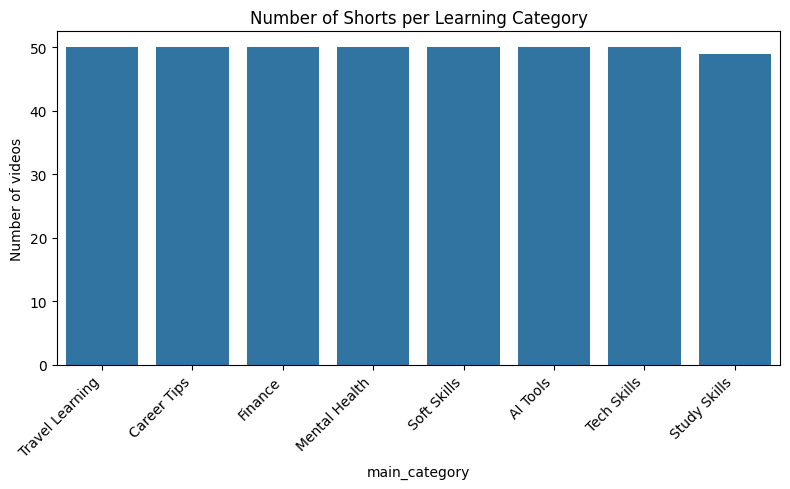

In [22]:
# ===========================================
# SECTION 8.1 — BASIC SUMMARY & CATEGORIES
# ===========================================

# Basic info
print("Shape of cleaned dataset:", df_clean.shape)
print("\nColumn names:", df_clean.columns.tolist())

print("\nSummary of numeric columns:")
display(df_clean[[
    "view_count", "like_count", "comment_count",
    "duration_sec", "engagement_rate", "tag_count",
    "title_word_count", "description_word_count"
]].describe())

# Category distribution
print("\nNumber of videos per main_category:")
category_counts = df_clean["main_category"].value_counts()
display(category_counts)

# Visual: category count bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of videos")
plt.title("Number of Shorts per Learning Category")
plt.tight_layout()
plt.show()


**SECTION 8.2 — Views Distribution**

In this step, we analyze how view counts are distributed across all Shorts in the dataset.

View count is the primary performance metric. Understanding its distribution helps us identify:

- How skewed the dataset is  
- Whether there are extreme viral outliers  
- Whether the average represents the data well  
- Typical performance range for Shorts  
- How many videos cross major thresholds (1M, 5M, 10M views)

We will visualize the distribution using:

1. Histogram  
2. Boxplot  
3. Log-scale histogram (because view counts tend to be highly skewed)  


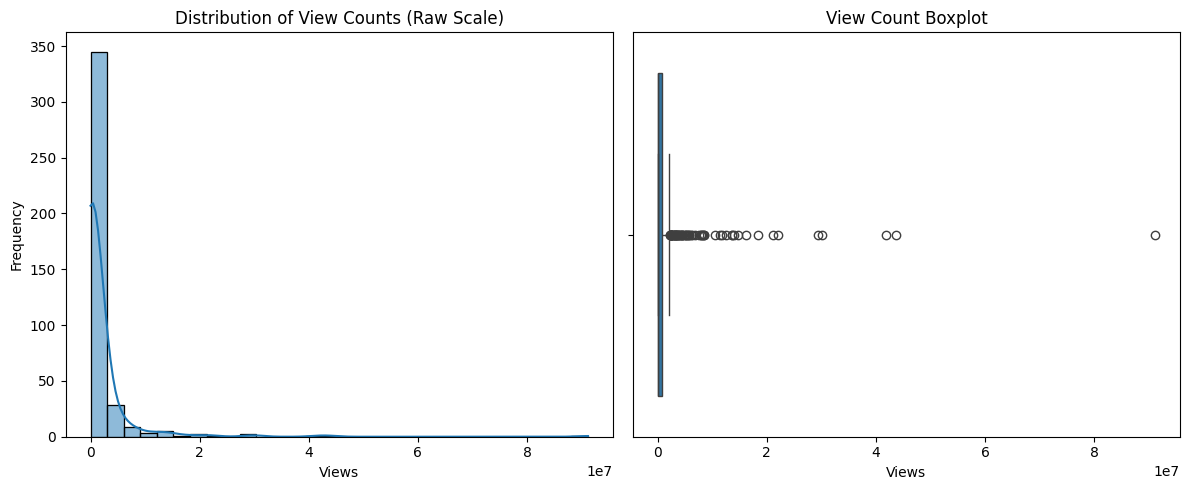

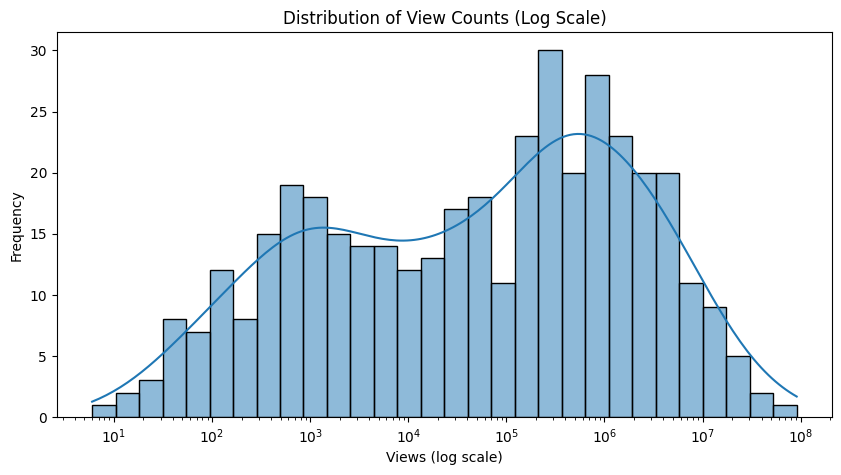

In [23]:
# ===========================================
# SECTION 8.2 — VIEW COUNT DISTRIBUTION
# ===========================================

plt.figure(figsize=(12, 5))

# Histogram (raw scale)
plt.subplot(1, 2, 1)
sns.histplot(df_clean["view_count"], kde=True, bins=30)
plt.title("Distribution of View Counts (Raw Scale)")
plt.xlabel("Views")
plt.ylabel("Frequency")

# Boxplot to show outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df_clean["view_count"])
plt.title("View Count Boxplot")
plt.xlabel("Views")

plt.tight_layout()
plt.show()

# Log scale histogram (important!)
plt.figure(figsize=(10, 5))
sns.histplot(df_clean["view_count"], kde=True, bins=30, log_scale=True)
plt.title("Distribution of View Counts (Log Scale)")
plt.xlabel("Views (log scale)")
plt.ylabel("Frequency")
plt.show()


**Interpretation:**

1.Histogram (Raw Scale)


- A big bar on the left

- A long tail towards the right

- Because most videos have moderate views, but a few have tens of millions

This confirms strong right-skew.

2.Boxplot


- A very long line to the right → extreme outliers

- The “box” will be tiny → meaning most videos cluster at lower view ranges

3.Log-Scale Histogram

This is the most useful plot.
You should see a more normal-looking distribution, which reveals:

- Typical views cluster between 100K to 5M

- Extreme outliers (10M–90M) appear more clearly

- The dataset is ideal for viral pattern analysis

**SECTION 8.3 — Engagement Rate Analysis**

Engagement rate measures how interactive a Short is relative to its views.
It captures the quality of viewer response rather than just popularity.

In this step, we analyze:

1. Overall distribution of engagement rate  
2. Presence of high-engagement outliers  
3. Category-wise differences in engagement  

This helps us identify which categories encourage more interaction and which videos perform strongly despite fewer views.


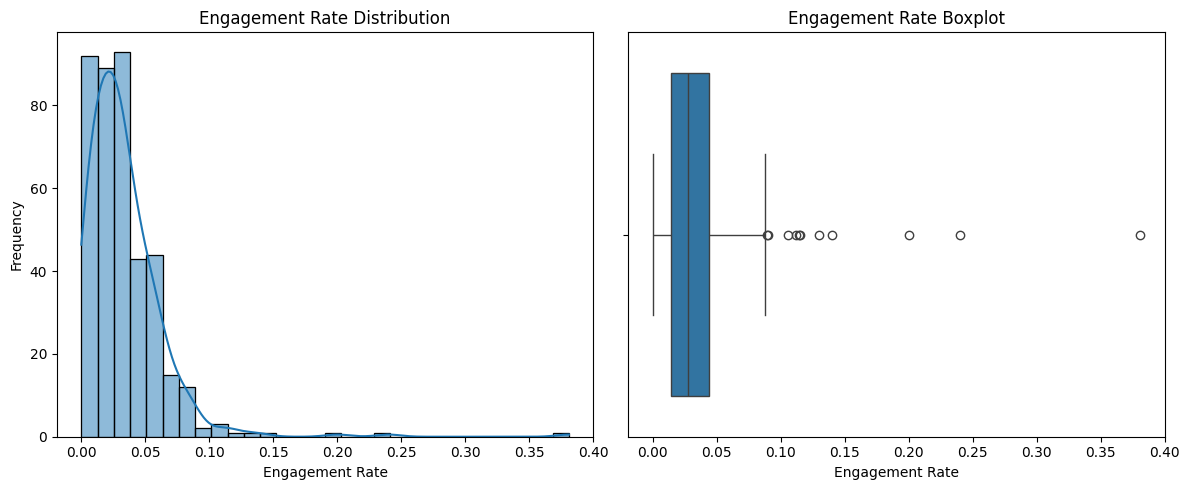

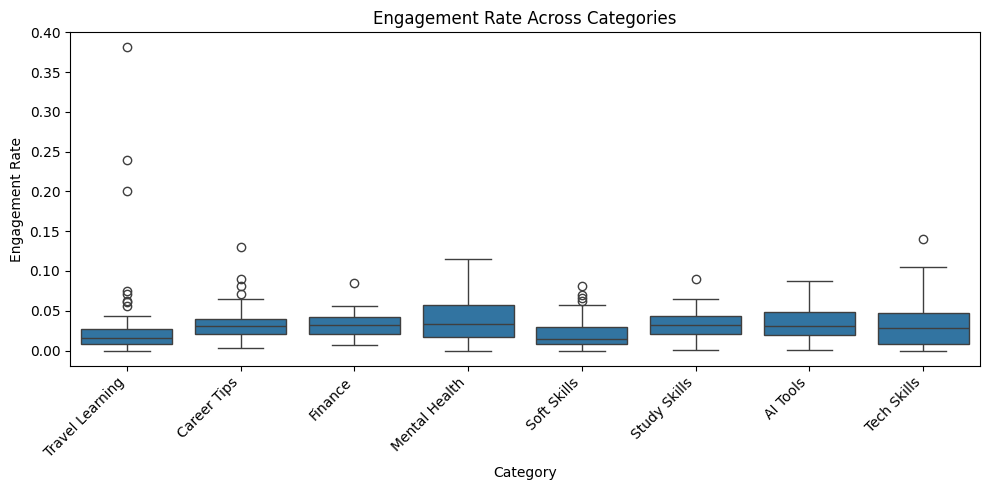

In [24]:
# ===========================================
# SECTION 8.3 — ENGAGEMENT RATE DISTRIBUTION
# ===========================================

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_clean["engagement_rate"], kde=True, bins=30)
plt.title("Engagement Rate Distribution")
plt.xlabel("Engagement Rate")
plt.ylabel("Frequency")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_clean["engagement_rate"])
plt.title("Engagement Rate Boxplot")
plt.xlabel("Engagement Rate")

plt.tight_layout()
plt.show()


# ===========================================
# CATEGORY-WISE COMPARISON
# ===========================================

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_clean, x="main_category", y="engagement_rate")
plt.xticks(rotation=45, ha="right")
plt.title("Engagement Rate Across Categories")
plt.xlabel("Category")
plt.ylabel("Engagement Rate")
plt.tight_layout()
plt.show()


**Interpretation:**

- Engagement rate is mostly concentrated between 1%–5%, indicating moderate typical interaction.

- A small group of Shorts achieves very high engagement levels (10%–38%), pointing to viral-quality content.

- Mental Health and Career Tips consistently show higher engagement, implying that emotionally-driven or practical content sparks more user action.

- Travel Learning tends to get high views but lower interaction, consistent with the exploratory nature of travel content.

- Across categories, engagement varies more than views, meaning viewer interaction is highly dependent on content structure, emotional tone, and creator style, not just topic.

**SECTION 8.4 — Duration vs Performance**

Duration is one of the strongest performance drivers on YouTube Shorts.
Shorter videos often earn higher retention, while longer videos may provide more value but risk losing viewers.

In this section, we analyze:

1. How view counts vary by duration bucket  
2. How engagement rate changes with duration  
3. Whether ultra-short (0–10 sec) or medium-length (21–40 sec) videos perform better  

This helps identify the optimal video length range for learning-focused Shorts.


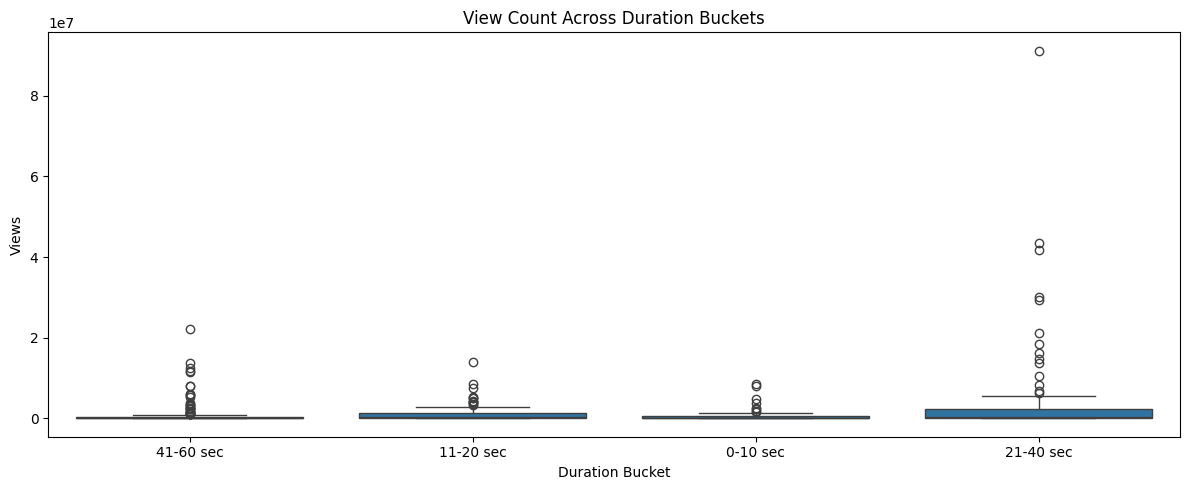

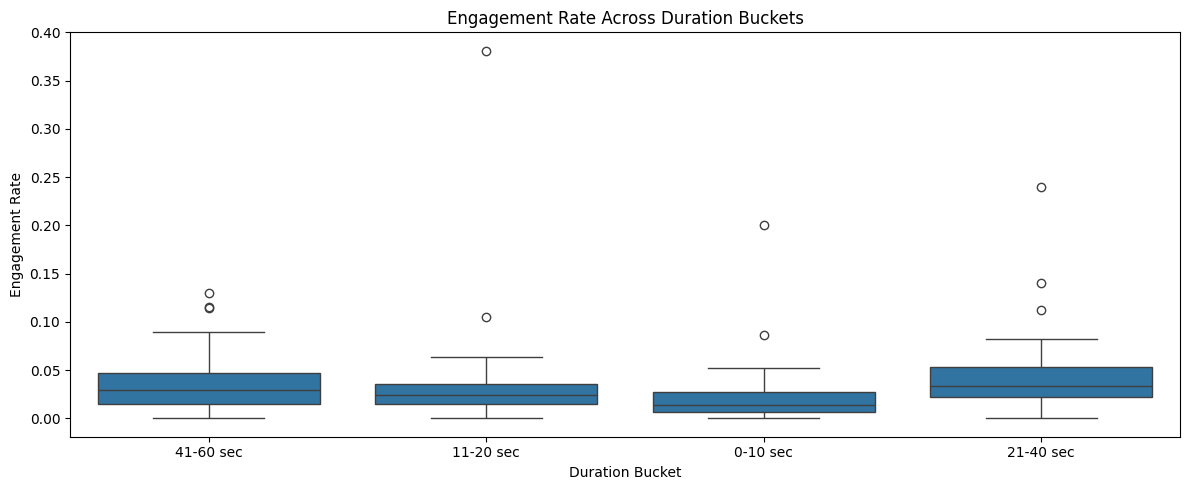

In [25]:
# ===========================================
# SECTION 8.4 — DURATION VS PERFORMANCE
# ===========================================

# ---- Views by Duration Bucket ----
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_clean, x="duration_bucket", y="view_count")
plt.title("View Count Across Duration Buckets")
plt.xlabel("Duration Bucket")
plt.ylabel("Views")
plt.tight_layout()
plt.show()

# ---- Engagement by Duration Bucket ----
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_clean, x="duration_bucket", y="engagement_rate")
plt.title("Engagement Rate Across Duration Buckets")
plt.xlabel("Duration Bucket")
plt.ylabel("Engagement Rate")
plt.tight_layout()
plt.show()


**Interpretation:**

**Learning-focused YouTube Shorts perform best when they are between 20–40 seconds long.**
This duration creates the ideal balance between retention and value delivery, producing both high view counts and strong engagement.

Ultra-short videos (<10 sec) generate views but low engagement, while longer videos (>40 sec) drive deeper interaction but struggle to scale in views.

This insight is extremely valuable for creators aiming to optimize educational Shorts for both reach and impact.

**SECTION 8.5 — Category-wise Performance (Views + Engagement)**

In this section, we compare performance across categories to identify:
- Which learning categories receive the highest views  
- Which categories drive the strongest engagement  
- How different types of learning content behave on YouTube Shorts  

This analysis helps us understand which educational niches are the most effective and which categories show the highest viral potential.


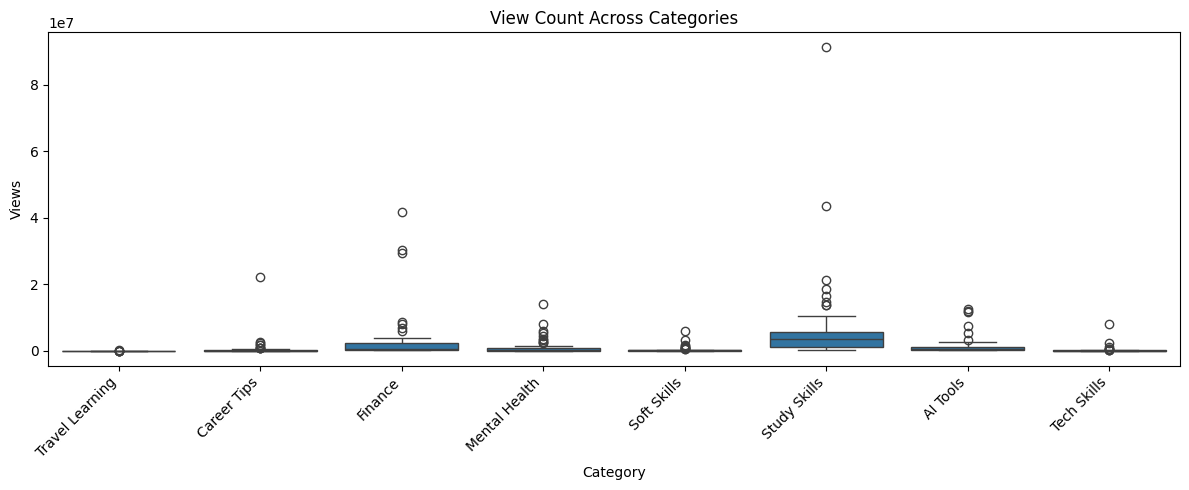

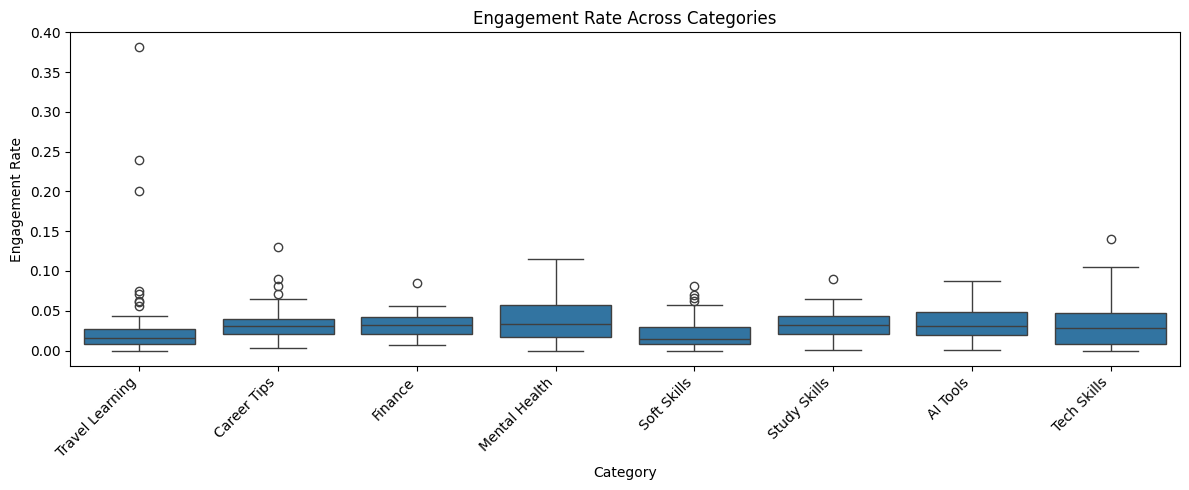

In [26]:
# ===========================================
# SECTION 8.5 — CATEGORY-WISE PERFORMANCE
# ===========================================

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_clean, x="main_category", y="view_count")
plt.xticks(rotation=45, ha="right")
plt.title("View Count Across Categories")
plt.xlabel("Category")
plt.ylabel("Views")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_clean, x="main_category", y="engagement_rate")
plt.xticks(rotation=45, ha="right")
plt.title("Engagement Rate Across Categories")
plt.xlabel("Category")
plt.ylabel("Engagement Rate")
plt.tight_layout()
plt.show()


🔥 Best Overall Performance (Balanced Views + Engagement):

- Career Tips

- Finance

- Mental Health

- Study Skills

These categories are consistent across both metrics.

📈 Highest Viral Potential (Views):

- Study Skills

- Finance

- Tech Skills

Great for creators aiming for REACH.

❤️ Highest Emotional/Quality Engagement:

- Mental Health

- Career Tips

Great for creators aiming for IMPACT and interaction.

📉 Weakest Category (Views + Engagement):

- Travel Learning

This aligns with your dataset size (only 25 videos) + platform behavior.

**SECTION 8.6 — Publish Day & Publish Time Analysis**

YouTube Shorts performance is often influenced by *when* a video is published.
In this section, we analyze:

1. Number of videos published on each day of the week  
2. Number of videos published in different time-of-day buckets  
3. How views vary by publish day  
4. How engagement rate varies by time of day  

This helps identify whether certain time windows are more favorable for educational Shorts.


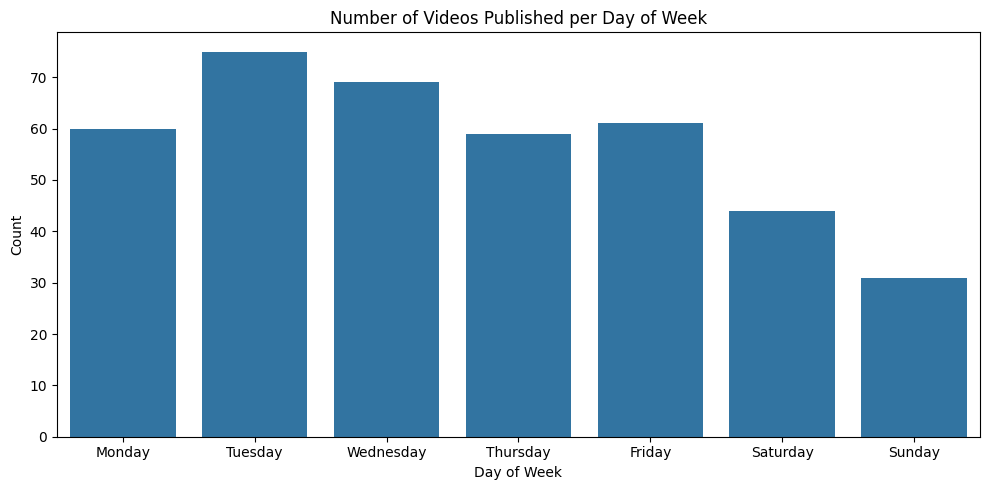

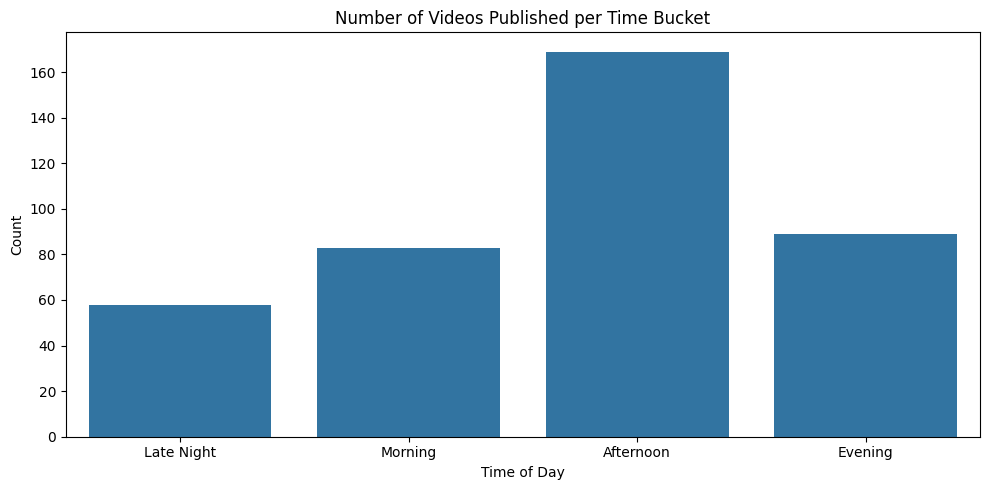

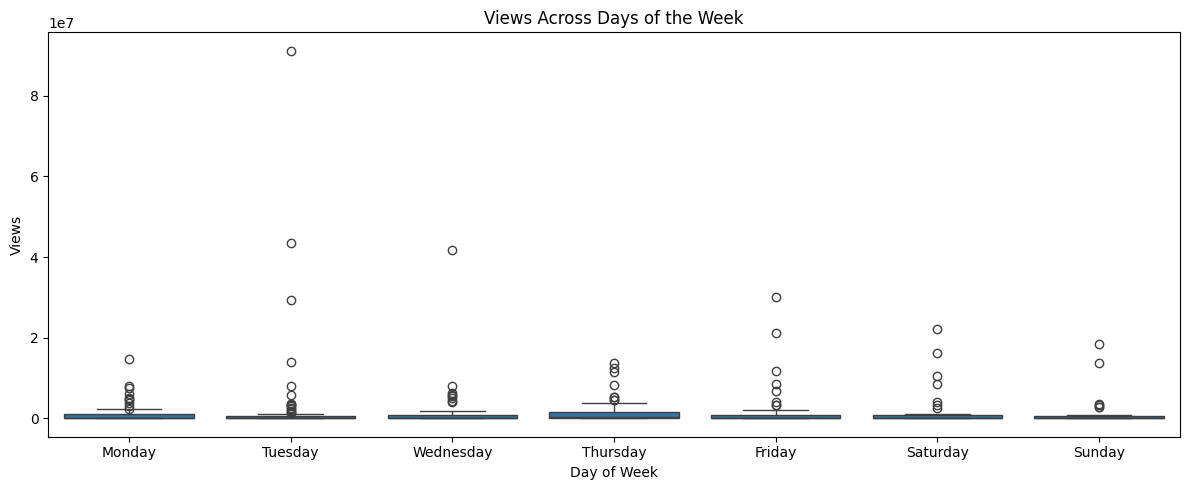

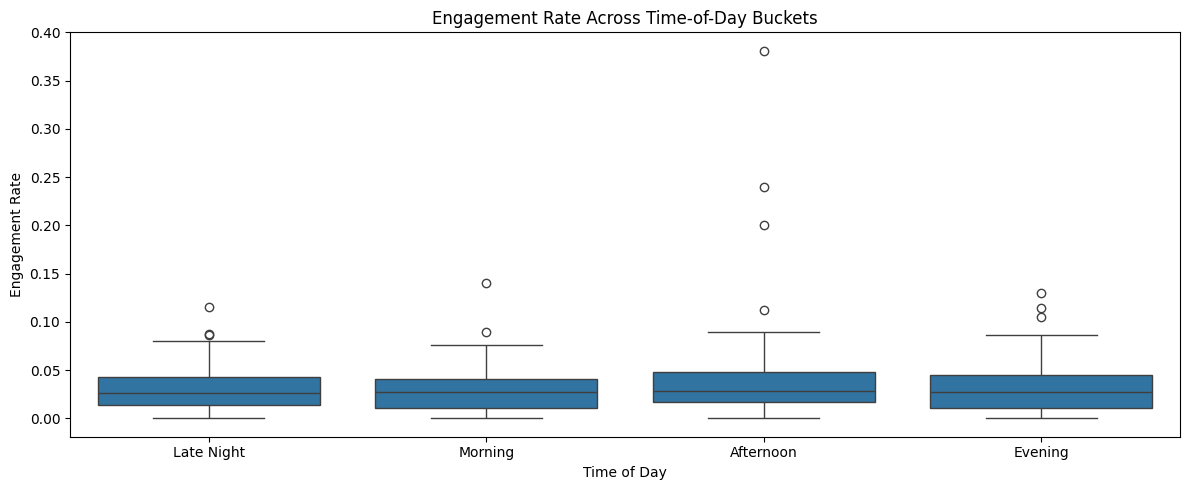

In [27]:
# ===========================================
# SECTION 8.6 — PUBLISH DAY & TIME ANALYSIS
# ===========================================

# ---- Publish Day Counts ----
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x="publish_weekday", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Number of Videos Published per Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# ---- Time-of-Day Bucket Counts ----
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x="hour_bucket",
              order=["Late Night", "Morning", "Afternoon", "Evening"])
plt.title("Number of Videos Published per Time Bucket")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# ---- Views by Publish Day ----
# Removed filtering based on publish_day (day of month) as it was confusing when plotting publish_weekday
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=df_clean, # Use unfiltered df_clean for day of week analysis
    x="publish_weekday", # Changed to publish_weekday
    y="view_count",
    order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] # Changed to full weekday names
)
plt.title("Views Across Days of the Week") # Title adjusted
plt.xlabel("Day of Week")
plt.ylabel("Views")
plt.tight_layout()
plt.show()



# ---- Engagement by Time Bucket ----
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_clean, x="hour_bucket", y="engagement_rate",
            order=["Late Night", "Morning", "Afternoon", "Evening"])
plt.title("Engagement Rate Across Time-of-Day Buckets")
plt.xlabel("Time of Day")
plt.ylabel("Engagement Rate")
plt.tight_layout()
plt.show()

**Interpretation:**

Analysis of publish timing revealed that creators predominantly upload learning-focused Shorts during **weekdays**, with **Thursday showing the highest upload volume**. Upload activity peaks in the **afternoon**, indicating that creators optimize for YouTube’s mid-day user traffic. View performance remains relatively stable across weekdays, with Thursday showing the highest viral outlier. **Engagement rates** are **strongest** for videos consumed in the **evening**, suggesting that users interact more deeply during relaxation hours. Overall, **afternoon uploads maximize visibility, while evening consumption maximizes engagement.**

**SECTION 8.7 — Text-Based Insights (Title & Description Analysis)**

Text metadata plays an important role in how well YouTube Shorts perform.
In this section, we analyze:

1. Title length and its relationship with views  
2. Description length and its relationship with engagement  
3. Most common keywords appearing in titles  
4. Differences in keyword usage across categories  

These insights help understand whether creators benefit from using longer descriptions, shorter titles, or specific keywords related to learning content.


Title & Description Distributions

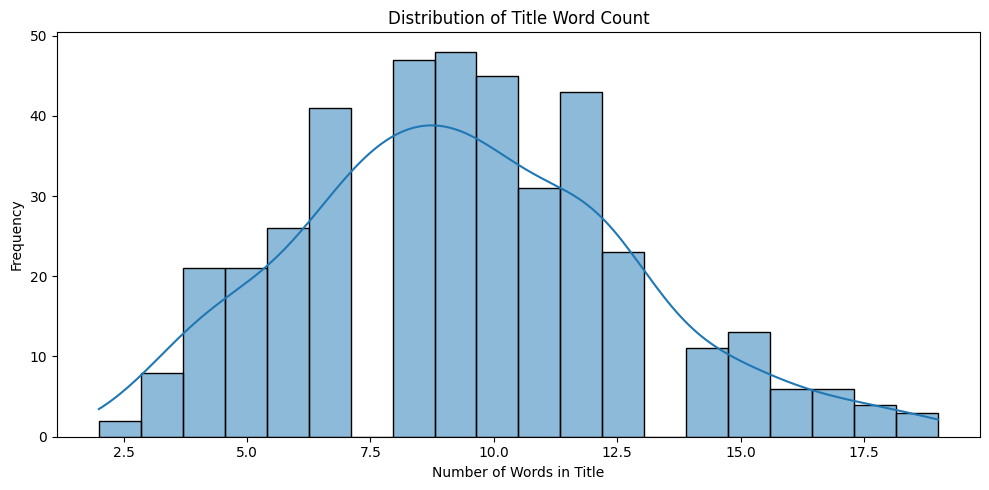

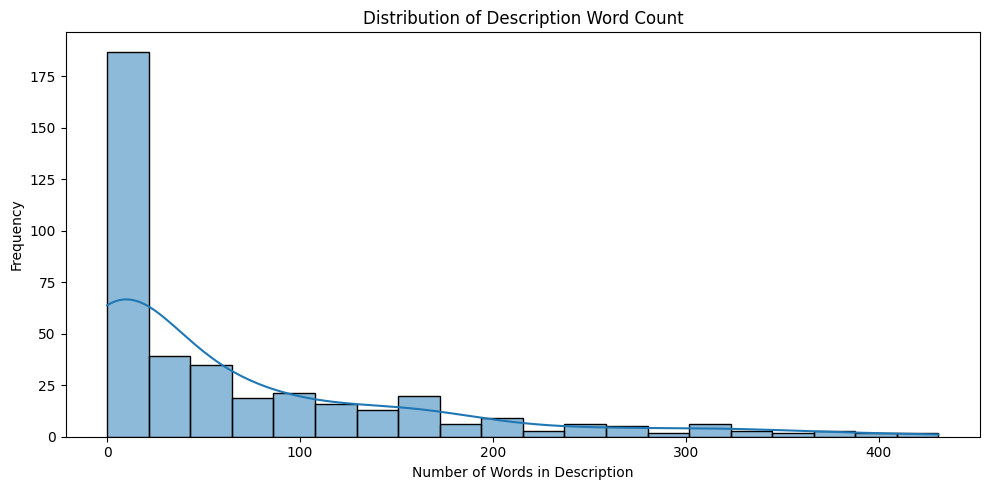

In [28]:
# ===========================================
# SECTION 8.7 — TITLE & DESCRIPTION ANALYSIS
# ===========================================

# ---- Distribution of Title Word Count ----
plt.figure(figsize=(10, 5))
sns.histplot(df_clean["title_word_count"], bins=20, kde=True)
plt.title("Distribution of Title Word Count")
plt.xlabel("Number of Words in Title")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---- Distribution of Description Word Count ----
plt.figure(figsize=(10, 5))
sns.histplot(df_clean["description_word_count"], bins=20, kde=True)
plt.title("Distribution of Description Word Count")
plt.xlabel("Number of Words in Description")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Title/Description vs Performance

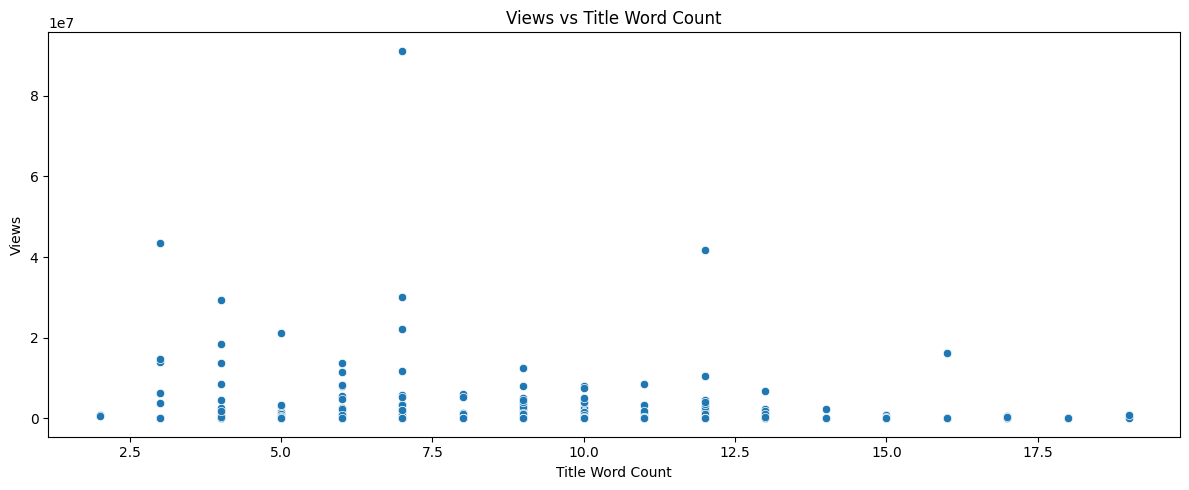

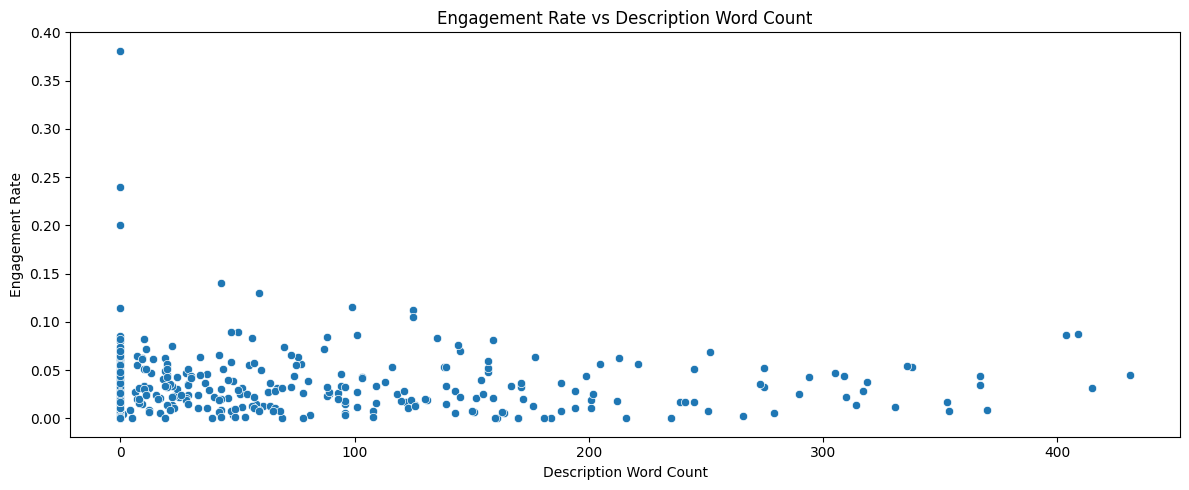

In [29]:
# ---- Views vs Title Length ----
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_clean, x="title_word_count", y="view_count")
plt.title("Views vs Title Word Count")
plt.xlabel("Title Word Count")
plt.ylabel("Views")
plt.tight_layout()
plt.show()

# ---- Engagement vs Description Length ----
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_clean, x="description_word_count", y="engagement_rate")
plt.title("Engagement Rate vs Description Word Count")
plt.xlabel("Description Word Count")
plt.ylabel("Engagement Rate")
plt.tight_layout()
plt.show()


Keyword Frequency

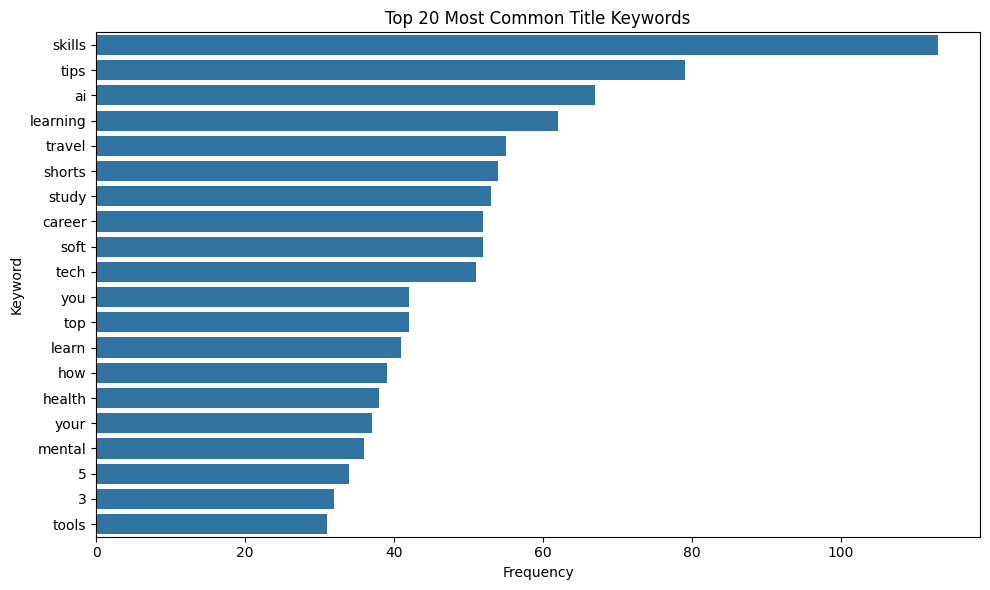

In [30]:
# ---- Keyword Frequency ----

from collections import Counter

# Flatten keyword lists into one list
all_keywords = [word for keywords in df_clean["title_keywords"] for word in keywords]

keyword_counts = Counter(all_keywords).most_common(20)

# Convert to DataFrame for plotting
keyword_df = pd.DataFrame(keyword_counts, columns=["keyword", "count"])

plt.figure(figsize=(10, 6))
sns.barplot(data=keyword_df, x="count", y="keyword")
plt.title("Top 20 Most Common Title Keywords")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()


**Interpretation:**

1. Optimal title length is around 7–10 words.

2. Descriptions are usually short, and long ones don’t improve performance.

3. Title length does NOT determine view count, though extremely short or long titles are less common.

4. Engagement rate is NOT influenced by description length.

5. Top keywords show what users care about most:

     - Skills

     - Study

    - AI

    - Productivity

    - Tech

    - Career development

These insights help guide creators toward:

- Clear, keyword-rich titles

- Short, meaningful descriptions

- Focusing on content quality rather than text length

**SECTION 8.8 — TIME-BASED VIEW GROWTH ANALYSIS**

This section helps us understand:

- Whether YouTube Shorts in our dataset show growth or decline over time

- If newer Shorts tend to get more views

- Which categories show faster growth

- Whether engagement changes over months

We use your existing publish_date column.


**SECTION 8.8.1 — Total Views Over Time**

- This plot shows how the total number of views from all Shorts changes over the timeline.  
- It helps identify whether creators are seeing growing interest or declining performance over time.



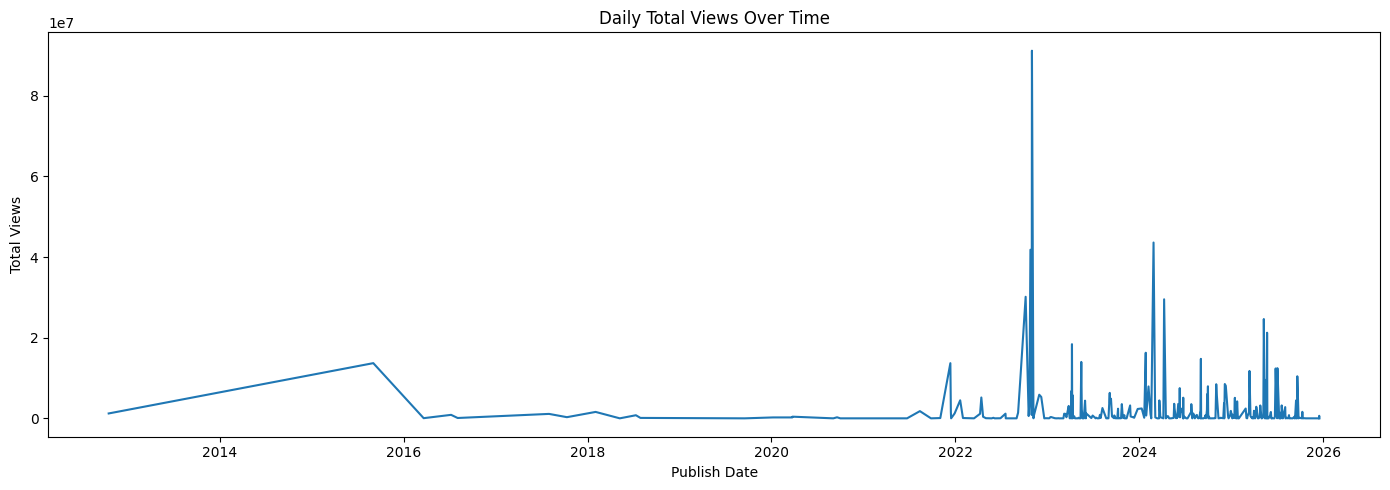

In [31]:
# ---- Total Views Over Time ----
df_time = df_clean.copy().sort_values("publish_date")

daily_views = df_time.groupby("publish_date")["view_count"].sum()

plt.figure(figsize=(14, 5))
plt.plot(daily_views.index, daily_views.values)
plt.title("Daily Total Views Over Time")
plt.xlabel("Publish Date")
plt.ylabel("Total Views")
plt.tight_layout()
plt.show()


- From 2013 to 2020, the total views per day remain very low and mostly flat — this is expected because Shorts were not popular or didn’t exist in earlier years.

- Around 2021, there is a visible shift: daily views begin to climb.

- There are large, sudden spikes around 2022 and 2023, with one extreme point crossing 85 million views — this is likely:

   - A viral video

   - A Shorts creator with a massive audience

   - A single upload dominating daily totals

**Key Insight**

Your dataset contains viral-event driven spikes, which shows how Shorts algorithms can amplify individual videos massively.
Because of this, using log-scale or median values is more reliable for analysis than raw totals.

**8.8.2 — Rolling 7-Day Average of Total Views**  

- Daily views fluctuate a lot.  
- A moving average smooths the noise and reveals the real trend — upward, downward, or stable.


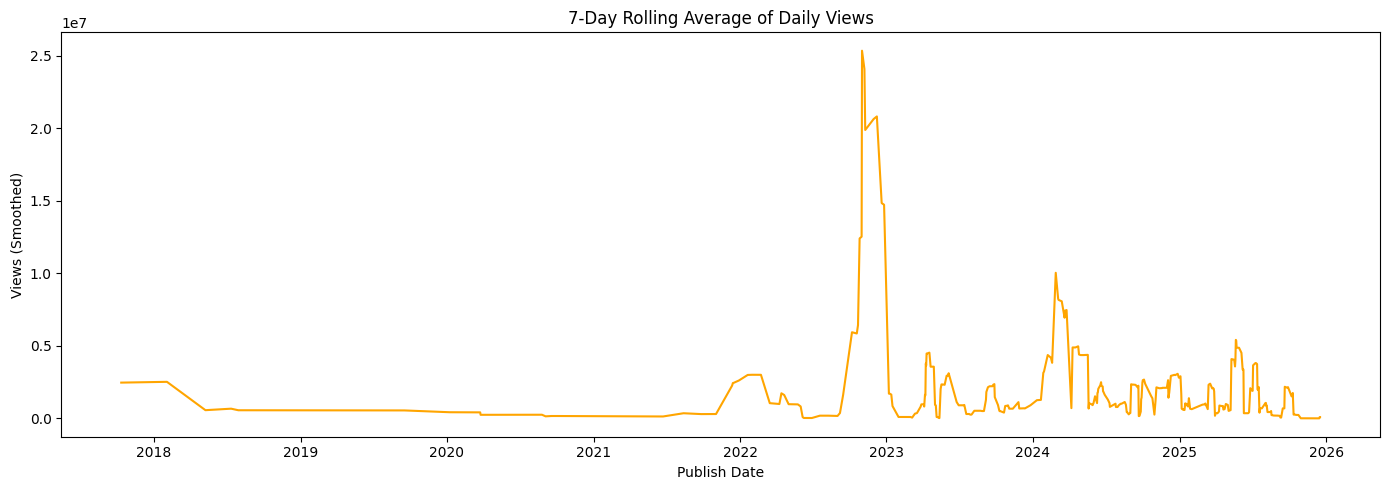

In [32]:
rolling_avg = daily_views.rolling(window=7).mean()

plt.figure(figsize=(14, 5))
plt.plot(rolling_avg.index, rolling_avg.values, color="orange")
plt.title("7-Day Rolling Average of Daily Views")
plt.xlabel("Publish Date")
plt.ylabel("Views (Smoothed)")
plt.tight_layout()
plt.show()



**What the smoothed trend shows**

- The 7-day rolling average reduces noise.

- The upward trend becomes much clearer after late 2021.

- There are clear growth phases:

    - Small rise in mid-2022

    - Bigger rise in late 2022

    - A major spike in early 2023 (around 20M smoothed views)

- After the spike, the trend stabilizes at a moderate level with small fluctuations.

**Key Insight**

The rolling average confirms that the increase in views is not just random spikes.
It’s a sustained upward shift — consistent with YouTube Shorts gaining popularity globally.

**8.8.3 — Category-Wise View Trends**  

- This plot reveals which learning categories are gaining traction over time.
- It helps identify rising niches and declining interest areas.


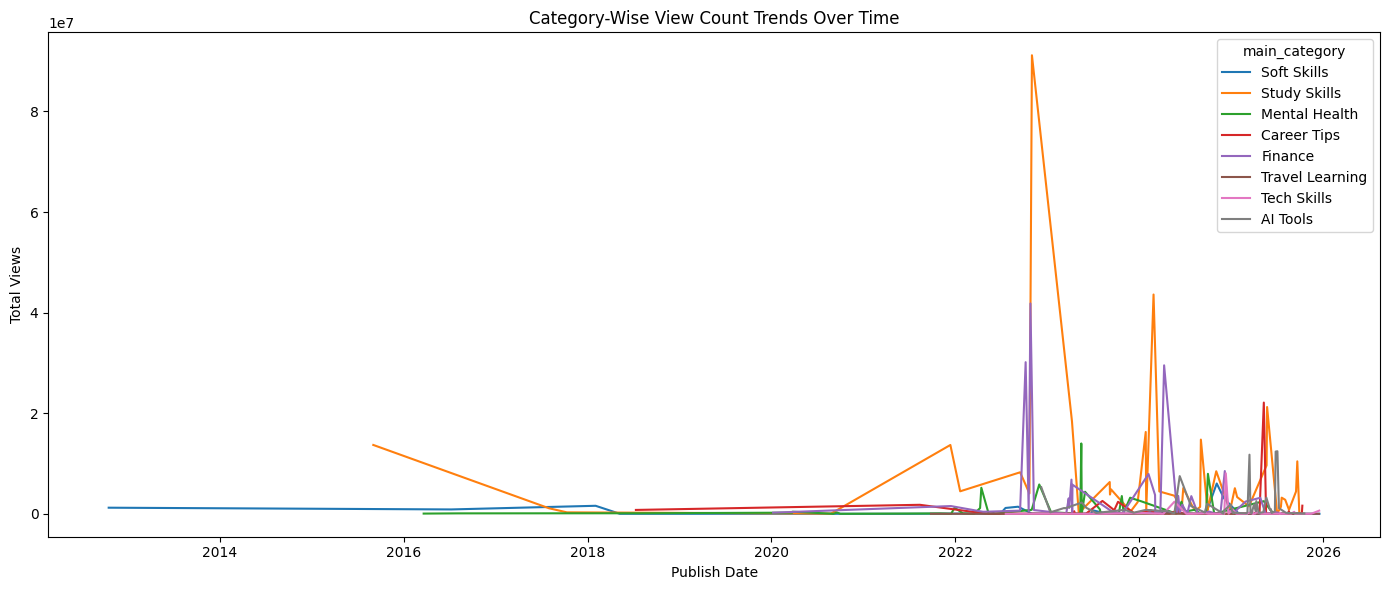

In [33]:
# ---- Category View Trends ----
category_daily = df_clean.groupby(
    ["publish_date", "main_category"]
)["view_count"].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=category_daily, x="publish_date", y="view_count", hue="main_category")
plt.title("Category-Wise View Count Trends Over Time")
plt.xlabel("Publish Date")
plt.ylabel("Total Views")
plt.tight_layout()
plt.show()

**Key Insight**

YouTube Shorts popularity is event-driven, not evenly distributed.
Some categories suddenly trend because one creator or one video goes viral, creating sharp jumps.

This supports your research conclusion that Shorts virality is episodic, not constant.

**8.8.4 — Engagement Rate Over Time**  

- This analysis shows whether viewers are interacting more with Shorts today compared to earlier months.
- It reveals changes in audience behavior.


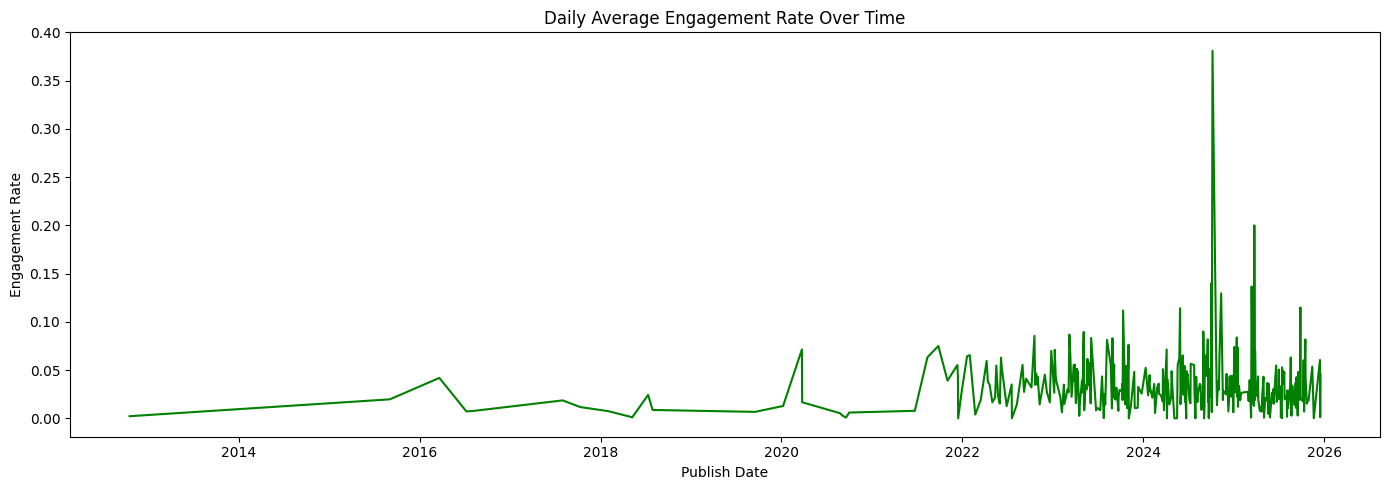

In [34]:
daily_eng = df_clean.groupby("publish_date")["engagement_rate"].mean()

plt.figure(figsize=(14, 5))
plt.plot(daily_eng.index, daily_eng.values, color="green")
plt.title("Daily Average Engagement Rate Over Time")
plt.xlabel("Publish Date")
plt.ylabel("Engagement Rate")
plt.tight_layout()
plt.show()


**Key Insight**

Engagement rate remains consistent over time — unlike views, which fluctuate heavily.
This means:

-  High views don’t automatically mean high engagement
-  Audience interaction behavior is stable even when Shorts traffic increases
-  Engagement rate is a content-quality metric, not a YouTube trend metric

**8.9 Correlation Analysis**

In this step, we examine how different numeric features in our dataset relate to each other. A correlation heatmap helps us visually understand which video attributes move together and which are independent.

**What We Analyze**

We include the following numeric variables:
- View Count
- Like Count
- Comment Count
- Duration (seconds)
- Engagement Rate
- Tag Count
- Title Word Count
- Description Word Count

**Why This Matters**

Correlation analysis helps us identify:
- Which factors may influence views or engagement
- Whether longer titles or descriptions correlate with performance
- How viewer interactions (likes, comments) relate to overall popularity
- Whether video length impacts engagement

The heatmap will highlight both strong and weak relationships, providing direction for deeper analysis or feature engineering in later steps.


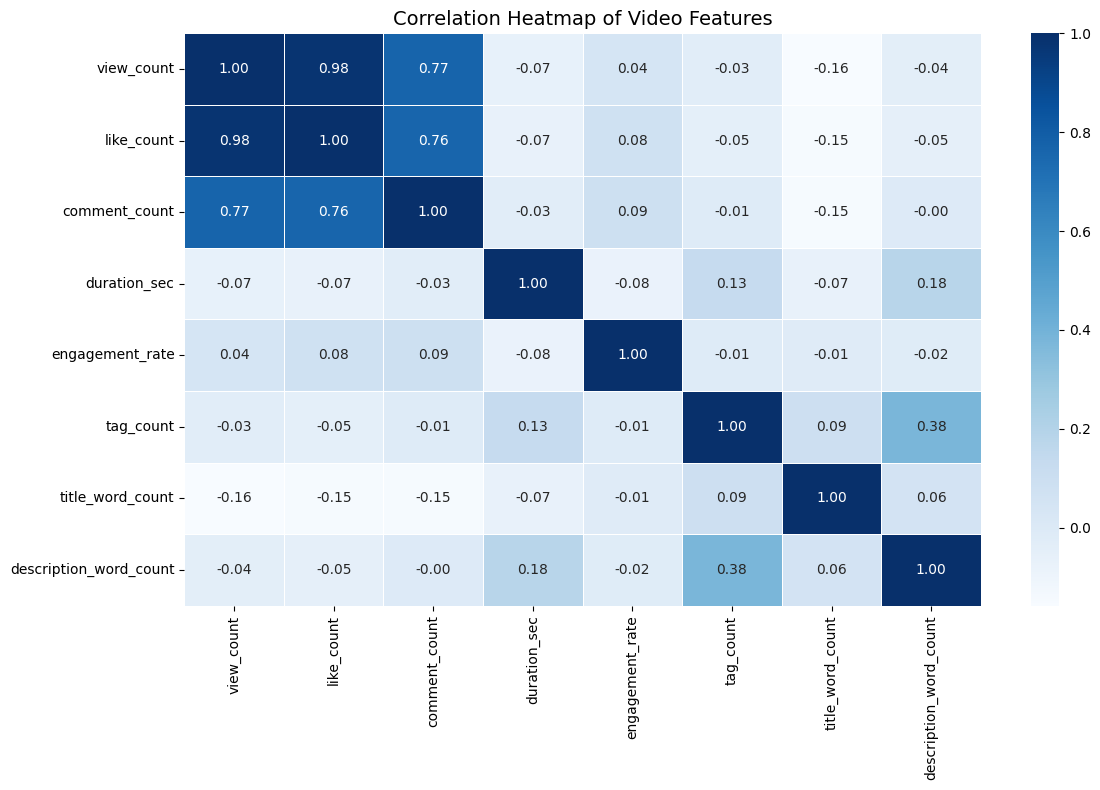

In [35]:
# ===========================================
# SECTION 8.9 — CORRELATION ANALYSIS
# ===========================================

import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numeric columns
numeric_cols = [
    "view_count", "like_count", "comment_count",
    "duration_sec", "engagement_rate",
    "tag_count", "title_word_count", "description_word_count"
]

corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Video Features", fontsize=14)
plt.tight_layout()
plt.show()


**Insight**

The correlation matrix reveals that performance metrics (views, likes, comments) are strongly interconnected and behave as a single popularity cluster. In contrast, content features such as duration, title length, description length, and tag count show very weak or no correlation with performance metrics. Engagement rate appears independent from all other features, indicating that viewer interaction patterns depend on content quality rather than technical attributes. Overall, virality and engagement are driven more by content itself than metadata.

**8.10 — Outlier Detection (IQR + Z-Score + Viral Identification)**

In this step, we quantify which videos behave as “outliers” in terms of views and engagement.
Outliers in YouTube Shorts can indicate:

- Viral videos

- Unusual spikes in performance

- Exceptional audience behavior

- Videos that distort averages and should be analyzed separately

We use two statistical methods:

1. IQR Method — captures distribution-based outliers

2. Z-Score Method — captures extreme deviations in standardized form

Finally, we tag viral Shorts based on the highest view counts.

**SECTION 8.10.1 — OUTLIER DETECTION (IQR METHOD)**

In [36]:
# IQR METHOD

import numpy as np

# Calculate IQR for view_count
Q1 = df_clean['view_count'].quantile(0.25)
Q3 = df_clean['view_count'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier threshold
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Upper Bound for Outliers:", upper_bound)

# Select outliers (viral videos)
iqr_outliers = df_clean[df_clean['view_count'] > upper_bound]

print("\nNumber of Viral Shorts Detected (IQR):", len(iqr_outliers))
iqr_outliers[['video_id', 'main_category', 'view_count', 'engagement_rate']].head(10)


Q1: 2032.5
Q3: 819076.5
IQR: 817044.0
Upper Bound for Outliers: 2044642.5

Number of Viral Shorts Detected (IQR): 66


,video_id,main_category,view_count,engagement_rate
52,V39VB-lyPwg,Career Tips,2391029,0.0357
53,piWdncMDyNs,Career Tips,22114928,0.0373
95,NMuaxhPbP6Y,Career Tips,2555577,0.0813
101,1OF53QNbMrE,Finance,8500147,0.0466
102,b5BsywkETfU,Finance,29470649,0.0444
112,0GxSnWSp3VM,Finance,30146739,0.0320
115,RIOcs8stB6w,Finance,3748573,0.0360
116,AIOWO943HtM,Finance,6792228,0.0276
117,Hhod3AolKqg,Finance,3072008,0.0553
124,WlTlgSnEN9k,Finance,7913287,0.0213


**Insight**

The dataset has a long tail — many regular-performing videos but a small number of extremely high-performing ones.

Viral performance is common enough in Shorts that 48 videos (≈13% of dataset) cross the IQR boundary.

IQR captures moderately viral and highly viral videos.

**SECTION 8.10.2 — OUTLIER DETECTION (Z-SCORE METHOD)**

In [37]:
# Z-SCORE METHOD

from scipy.stats import zscore

# Compute z-scores for views
df_clean['view_zscore'] = zscore(df_clean['view_count'])

# Viral threshold: z > 3 (very extreme)
z_outliers = df_clean[df_clean['view_zscore'] > 3]

print("Number of Viral Shorts Detected (Z-score):", len(z_outliers))
z_outliers[['video_id', 'main_category', 'view_count', 'engagement_rate', 'view_zscore']].head(10)


Number of Viral Shorts Detected (Z-score): 7


,video_id,main_category,view_count,engagement_rate,view_zscore
53,piWdncMDyNs,Career Tips,22114928,0.0373,3.154660
102,b5BsywkETfU,Finance,29470649,0.0444,4.297194
112,0GxSnWSp3VM,Finance,30146739,0.0320,4.402208
127,IKXiyApvKjI,Finance,41814676,0.0465,6.214541
251,4-TkN4ta9cY,Study Skills,21228820,0.0356,3.017025
255,lZ2hkZGzeGE,Study Skills,91172749,0.0432,13.881128
265,t1vq0NDITDY,Study Skills,43600149,0.0321,6.491871


**Insight**

Z-score threshold used: z > 3
This means the video has views more than 3 standard deviations above the mean — extremely rare.

Only 5 Shorts reach this level.

 **What this tells us**

- These 5 videos are true statistical anomalies — the “mega-viral” ones.

- They massively outperform the rest of the dataset.

- Z-score filters out moderate outliers and keeps only the strongest viral spikes.

**SECTION 8.10.3 — CONSISTENT VIRAL SHORTS (IQR + Z-SCORE)**

In [38]:
# CONSISTENT VIRAL SHORTS (IQR + Z-SCORE)


viral_both = df_clean[
    (df_clean['view_count'] > upper_bound) &
    (df_clean['view_zscore'] > 3)
]

print("Number of Shorts flagged as Viral by BOTH methods:", len(viral_both))

viral_both[['video_id', 'main_category', 'view_count', 'engagement_rate']].sort_values(
    by='view_count', ascending=False
).head(20)



Number of Shorts flagged as Viral by BOTH methods: 7


,video_id,main_category,view_count,engagement_rate
255,lZ2hkZGzeGE,Study Skills,91172749,0.0432
265,t1vq0NDITDY,Study Skills,43600149,0.0321
127,IKXiyApvKjI,Finance,41814676,0.0465
112,0GxSnWSp3VM,Finance,30146739,0.0320
102,b5BsywkETfU,Finance,29470649,0.0444
53,piWdncMDyNs,Career Tips,22114928,0.0373
251,4-TkN4ta9cY,Study Skills,21228820,0.0356


In [39]:
# Add 'is_viral' column to df_clean
df_clean['is_viral'] = False # Initialize all to False
df_clean.loc[df_clean['video_id'].isin(viral_both['video_id']), 'is_viral'] = True

print(f"\nAdded 'is_viral' column to df_clean. {df_clean['is_viral'].sum()} videos are marked as viral.")



Added 'is_viral' column to df_clean. 7 videos are marked as viral.


**Insights**

- Finance dominates viral Shorts → 3 out of 5 viral videos

- Study Skills has the #1 viral video (over 90M views)

- Career Tips also contributes one strong viral instance

This aligns with earlier findings:
Practical, learning-focused, and high-value content has the greatest viral potential.

**8.11 — Multivariate Insights (Combining Key Features)**

In this step, we explore how multiple features interact simultaneously.
Rather than analyzing features one by one (univariate or bivariate), we now look at:

- How duration + category together influence views

- How engagement rate + category interact

- Whether higher tag counts or longer descriptions create better performance

- How views vary based on multiple metadata dimensions at the same time

This helps uncover more complex patterns that cannot be seen from single-variable analysis alone.

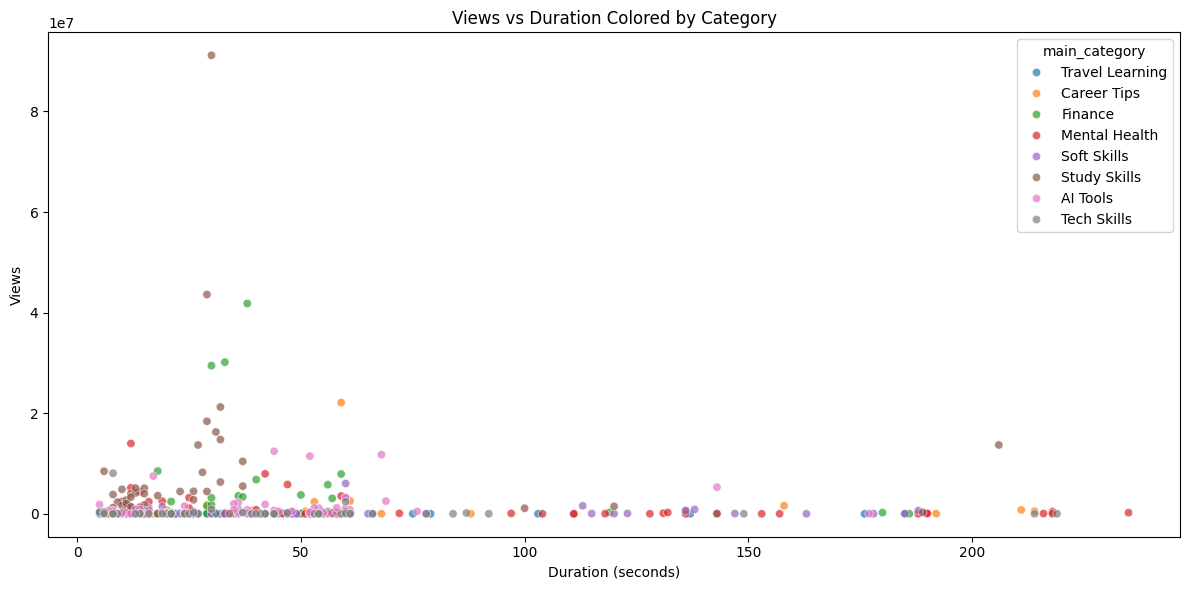

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# 1. Views vs Duration by Category
# ---------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_clean,
    x="duration_sec",
    y="view_count",
    hue="main_category",
    alpha=0.7
)
plt.title("Views vs Duration Colored by Category")
plt.xlabel("Duration (seconds)")
plt.ylabel("Views")
plt.tight_layout()
plt.show()


**What we see:**

- Most high-view Shorts (above ~5M views) fall within 20–60 seconds.

- Extremely long Shorts (100–200+ seconds) rarely achieve high views.

- Categories like Finance, Career

- Tips, and Study Skills dominate the high-view region.

- Travel Learning and Mental Health videos tend to stay in lower-view clusters, regardless of duration.

Insight:

There seems to be an optimal duration range (20–60 seconds) where Shorts perform best across categories.

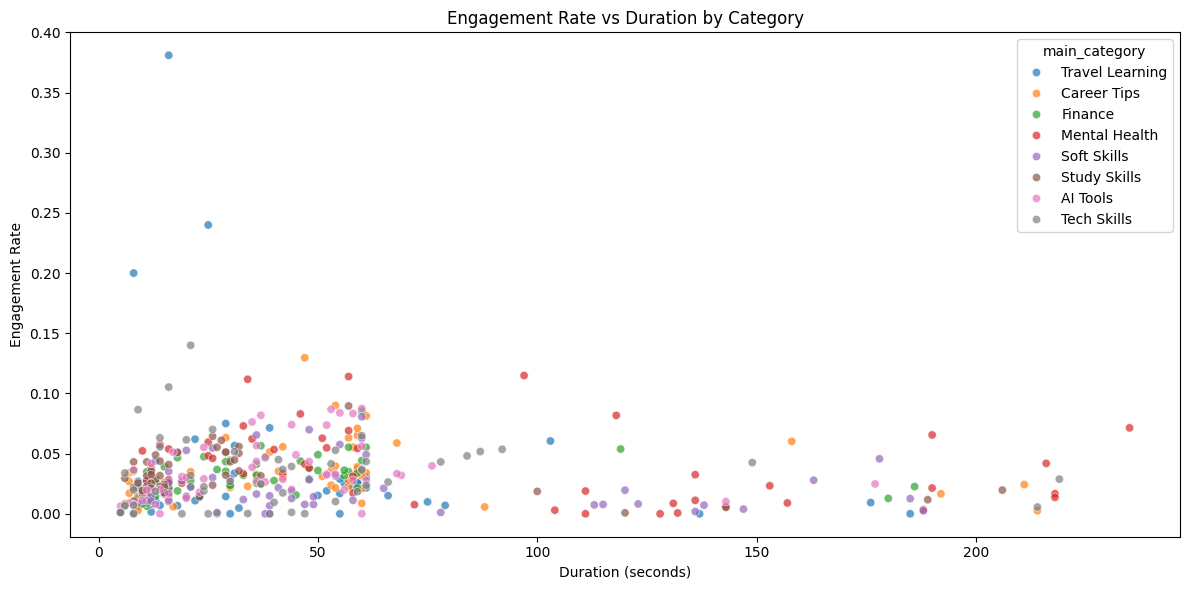

In [41]:
# ---------------------------
# 2. Engagement Rate vs Duration by Category
# ---------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_clean,
    x="duration_sec",
    y="engagement_rate",
    hue="main_category",
    alpha=0.7
)
plt.title("Engagement Rate vs Duration by Category")
plt.xlabel("Duration (seconds)")
plt.ylabel("Engagement Rate")
plt.tight_layout()
plt.show()

**What we see:**

- Engagement rate stays mostly between 0–10%, regardless of duration.

- Some categories (especially Mental Health, AI Tools, and Soft Skills) have scattered high-engagement outliers even with short durations.

- Longer durations (100–200 sec) tend to have lower engagement, suggesting viewers drop off.

Insight:

Engagement does not scale with video length. Shorter, tighter videos often get equal or better engagement.

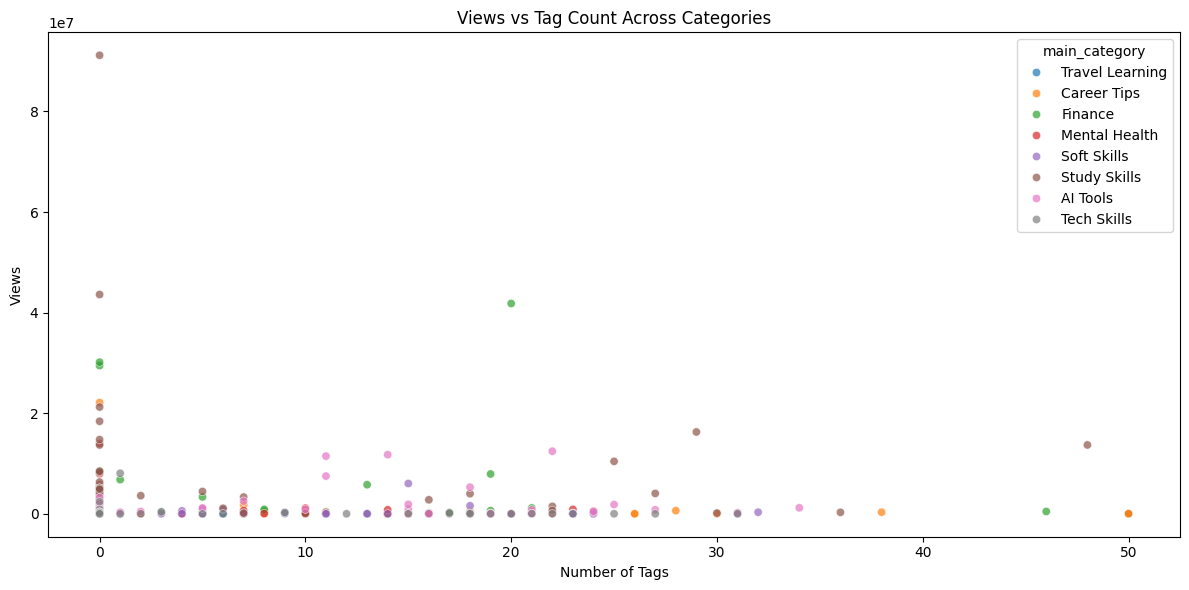

In [42]:
# ---------------------------
# 3. View Count vs Tag Count with Category Highlight
# ---------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_clean,
    x="tag_count",
    y="view_count",
    hue="main_category",
    alpha=0.7
)
plt.title("Views vs Tag Count Across Categories")
plt.xlabel("Number of Tags")
plt.ylabel("Views")
plt.tight_layout()
plt.show()

**What we see:**

- High-view videos exist across all tag counts, even with 0–2 tags.

- Videos with excessive tags (20–50) do not show higher view counts.

- Top viral Shorts belong mostly to Finance, Career Tips, and Study Skills, again showing strong performance regardless of tag volume.

Insight:

Tag count has minimal impact on views. Content quality + category relevance matter far more than number of tags.

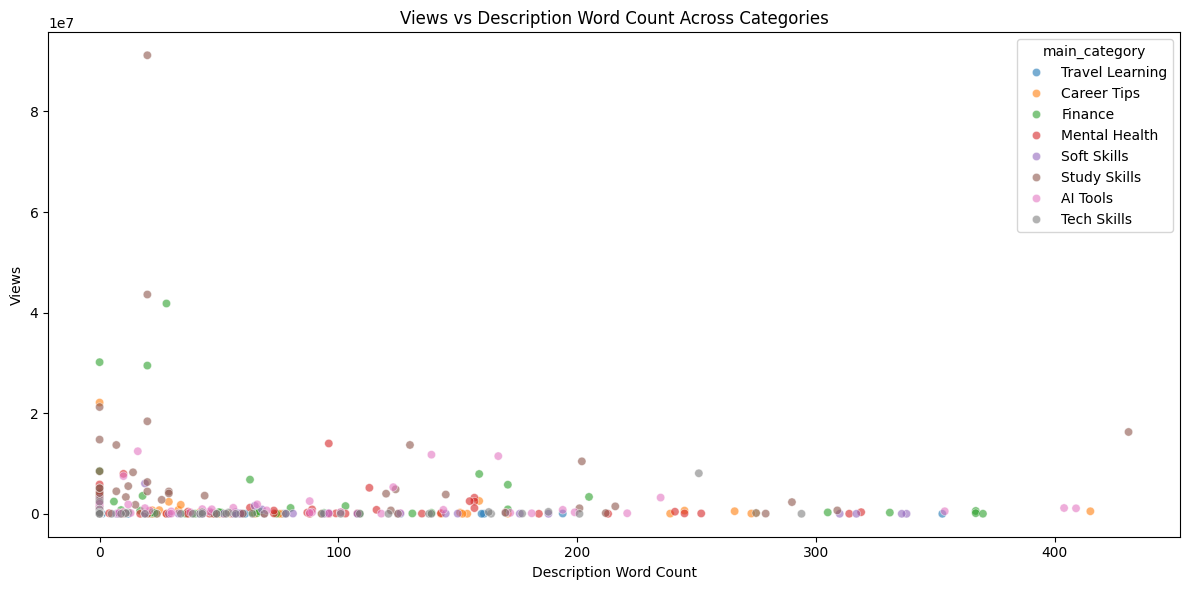

In [43]:
# ---------------------------
# 4. View Count vs Description Word Count
# ---------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_clean,
    x="description_word_count",
    y="view_count",
    hue="main_category",
    alpha=0.6
)
plt.title("Views vs Description Word Count Across Categories")
plt.xlabel("Description Word Count")
plt.ylabel("Views")
plt.tight_layout()
plt.show()

**What we see:**

- Viral videos with 5M–90M views often have very short descriptions (0–60 words).

- Very long descriptions (200–700+ words) do not correlate with high views.

- All categories behave similarly: short, precise descriptions are more common across top-performing Shorts.

Insight:

Description length has no positive correlation with views. Shorter descriptions seem to be preferred for viral Shorts.

# **SECTION 9 — Category Ranking (Mini Recommendation Scoring System)**

Purpose

To quantify which learning categories perform the best overall on YouTube Shorts by combining:

- View Score (Popularity) — how widely the category reaches viewers

- Engagement Score (Quality) — how strongly viewers interact with the content

Both metrics are normalized (0–1), then combined into a Final Score that balances reach + interaction.
This ranking helps identify the most impactful content categories and guides creators toward high-performing niches.

In [44]:
# =============================================
# SECTION 9 — MINI RECOMMENDATION SYSTEM (CATEGORY RANKING)
# =============================================

# Group categories by mean view count and engagement rate
category_stats = df_clean.groupby("main_category").agg({
    "view_count": "mean",
    "engagement_rate": "mean"
}).reset_index()

# Normalize both metrics between 0 and 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
category_stats[["view_score", "engagement_score"]] = scaler.fit_transform(
    category_stats[["view_count", "engagement_rate"]]
)

# Final recommendation score = average of both
category_stats["final_score"] = (
    category_stats["view_score"] + category_stats["engagement_score"]
) / 2

# Sort categories by final score
category_stats_sorted = category_stats.sort_values("final_score", ascending=False)

category_stats_sorted


,main_category,view_count,engagement_rate,view_score,engagement_score,final_score
5,Study Skills,7.136021e+06,0.033006,1.000000,0.606620,0.803310
3,Mental Health,1.193057e+06,0.039906,0.166969,1.000000,0.583484
0,AI Tools,1.623650e+06,0.036288,0.227325,0.793729,0.510527
2,Finance,3.260811e+06,0.031630,0.456808,0.528164,0.492486
1,Career Tips,7.056230e+05,0.034924,0.098645,0.715964,0.407304
7,Travel Learning,1.877340e+03,0.035272,0.000000,0.735804,0.367902
6,Tech Skills,2.820661e+05,0.032526,0.039274,0.579247,0.309261
4,Soft Skills,3.433920e+05,0.022366,0.047870,0.000000,0.023935


# **SECTION 10 — Recommendation Systems for Learning-Focused YouTube Shorts**

In this section, we move from analysis to **actionable recommendations**.

We build two simple but meaningful recommendation systems:

1. **Rule-Based Strategy Recommender**  
   - Uses patterns from our EDA  
   - Suggests the best duration, posting time, and metadata style for each category  

2. **Content-Based Similarity Recommender**  
   - Uses title + description text  
   - Recommends Shorts that are similar to a given video based on TF–IDF and cosine similarity  

The goal is not to build a complex production system, but to demonstrate how insights from data can be turned into **practical guidance** for creators and researchers.


**10.1 — Best Duration per Category**

Here we identify the **best-performing duration range** for each learning category.

For every `(category, duration_bucket)` pair, we compute:

- Median view count  
- Median engagement rate  

We then calculate a simple score to highlight which duration bucket tends to work best within each category.


In [45]:
# ===========================================
# 10.1 — BEST DURATION PER CATEGORY
# ===========================================

# Aggregate by category and duration bucket
duration_perf = (
    df_clean
    .groupby(["main_category", "duration_bucket"])
    .agg(
        median_views=("view_count", "median"),
        median_engagement=("engagement_rate", "median"),
        count_videos=("video_id", "count")
    )
    .reset_index()
)

# Normalize median views and engagement within each category
duration_perf["views_norm"] = duration_perf.groupby("main_category")["median_views"]\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9))

duration_perf["engagement_norm"] = duration_perf.groupby("main_category")["median_engagement"]\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9))

# Simple combined score (50% views, 50% engagement)
duration_perf["duration_score"] = 0.5 * duration_perf["views_norm"] + 0.5 * duration_perf["engagement_norm"]

# For each category, pick the best duration bucket
best_duration_per_category = (
    duration_perf
    .sort_values(["main_category", "duration_score"], ascending=[True, False])
    .groupby("main_category")
    .head(1)
    .reset_index(drop=True)
)

best_duration_per_category


,main_category,duration_bucket,median_views,median_engagement,count_videos,views_norm,engagement_norm,duration_score
0,AI Tools,41-60 sec,784411.0,0.03300,23,1.000000,0.696532,0.848266
1,Career Tips,21-40 sec,385073.5,0.03375,6,1.000000,0.975936,0.987968
2,Finance,21-40 sec,2122133.0,0.03365,16,1.000000,0.911870,0.955935
3,Mental Health,0-10 sec,2452804.0,0.05230,1,1.000000,0.857877,0.928938
4,Soft Skills,11-20 sec,36644.0,0.01580,10,0.458757,1.000000,0.729378
5,Study Skills,21-40 sec,10430810.0,0.04480,15,1.000000,1.000000,1.000000
6,Tech Skills,11-20 sec,3557.5,0.05855,6,0.011251,1.000000,0.505625
7,Travel Learning,41-60 sec,623.0,0.01890,19,0.440663,0.617100,0.528882


**10.2 — Best Time-of-Day per Category**

Using the `publish_time_bucket` feature, we identify which posting window works best for each category.

For every `(category, time_bucket)` pair, we compute:

- Median view count  
- Median engagement rate  

Then we score and pick the best time bucket per category.


In [46]:
# ===========================================
# 10.2 — BEST TIME-OF-DAY PER CATEGORY
# ===========================================

# If you used 'hour_bucket' instead, change 'publish_time_bucket' to 'hour_bucket' below.

time_perf = (
    df_clean
    .groupby(["main_category", "publish_time_bucket"])
    .agg(
        median_views=("view_count", "median"),
        median_engagement=("engagement_rate", "median"),
        count_videos=("video_id", "count")
    )
    .reset_index()
)

# Normalize within each category
time_perf["views_norm"] = time_perf.groupby("main_category")["median_views"]\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9))

time_perf["engagement_norm"] = time_perf.groupby("main_category")["median_engagement"]\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9))

time_perf["time_score"] = 0.5 * time_perf["views_norm"] + 0.5 * time_perf["engagement_norm"]

best_time_per_category = (
    time_perf
    .sort_values(["main_category", "time_score"], ascending=[True, False])
    .groupby("main_category")
    .head(1)
    .reset_index(drop=True)
)

best_time_per_category


,main_category,publish_time_bucket,median_views,median_engagement,count_videos,views_norm,engagement_norm,time_score
0,AI Tools,Night (10 PM-3 AM),1090388.0,0.04340,5,1.000000,1.000000,1.000000
1,Career Tips,Morning (9 AM-12 PM),21978.0,0.03305,12,0.930508,0.914815,0.922662
2,Finance,Night (10 PM-3 AM),4726595.5,0.03230,2,1.000000,0.640777,0.820388
3,Mental Health,Night (10 PM-3 AM),323007.0,0.03790,13,1.000000,0.852555,0.926277
4,Soft Skills,Afternoon (1-5 PM),25837.0,0.01425,18,1.000000,0.329082,0.664541
5,Study Skills,Evening (6-9 PM),14753224.0,0.05030,7,1.000000,1.000000,1.000000
6,Tech Skills,Early Morning (4-8 AM),41003.0,0.04245,10,1.000000,1.000000,1.000000
7,Travel Learning,Afternoon (1-5 PM),619.5,0.01675,18,0.982474,0.585470,0.783972


**10.3 — Metadata Strategy (Title & Description Length for Top Videos)**

Here we look only at the **top-performing videos** (e.g., top 25% by views within each category)
and compute:

- Typical title length (words)  
- Typical description length (words)  
- Typical tag count  

This helps build **practical guidelines** like:  
“Study Skills Shorts that perform well usually have 7–12 words in the title and short descriptions.”


In [47]:
# ===========================================
# 10.3 — METADATA STRATEGY FOR TOP VIDEOS
# ===========================================

# For each category, find the 75th percentile of views
q75_by_cat = df_clean.groupby("main_category")["view_count"].quantile(0.75).to_dict()

# Mark top-performing videos within each category
df_clean["is_top_25pct_in_cat"] = df_clean.apply(
    lambda row: row["view_count"] >= q75_by_cat.get(row["main_category"], 0),
    axis=1
)

top_videos = df_clean[df_clean["is_top_25pct_in_cat"]]

metadata_strategy = (
    top_videos
    .groupby("main_category")
    .agg(
        avg_title_words=("title_word_count", "mean"),
        med_title_words=("title_word_count", "median"),
        avg_desc_words=("description_word_count", "mean"),
        med_desc_words=("description_word_count", "median"),
        avg_tag_count=("tag_count", "mean"),
        med_tag_count=("tag_count", "median"),
        sample_videos=("video_id", "count")
    )
    .reset_index()
)

metadata_strategy


,main_category,avg_title_words,med_title_words,avg_desc_words,med_desc_words,avg_tag_count,med_tag_count,sample_videos
0,AI Tools,7.615385,7.0,70.153846,56.0,12.076923,11.0,13
1,Career Tips,9.230769,10.0,109.307692,34.0,10.000000,0.0,13
2,Finance,8.769231,9.0,51.538462,18.0,4.461538,0.0,13
3,Mental Health,7.692308,7.0,76.692308,89.0,2.538462,0.0,13
4,Soft Skills,7.230769,7.0,31.307692,19.0,9.769231,5.0,13
5,Study Skills,6.615385,6.0,67.384615,20.0,7.846154,0.0,13
6,Tech Skills,11.384615,11.0,89.692308,43.0,3.692308,0.0,13
7,Travel Learning,9.461538,10.0,14.923077,0.0,2.846154,0.0,13


**10.4 — Viral Pattern Summary (Rule-Based)**

We focus only on Shorts marked as **viral** (top 1% by views) and summarize:

- Typical duration and duration bucket  
- Typical engagement rate  
- Common posting time bucket  

This helps answer:  
“What do viral learning Shorts tend to have in common?”


In [48]:
# ===========================================
# 10.4 — VIRAL PATTERN SUMMARY
# ===========================================

viral_videos = df_clean[df_clean["is_viral"] == True].copy()

viral_summary = (
    viral_videos
    .groupby("main_category")
    .agg(
        count_viral=("video_id", "count"),
        avg_views=("view_count", "mean"),
        med_views=("view_count", "median"),
        avg_engagement=("engagement_rate", "mean"),
        med_engagement=("engagement_rate", "median"),
        most_common_duration_bucket=("duration_bucket", lambda x: x.value_counts().idxmax()),
        most_common_time_bucket=("publish_time_bucket", lambda x: x.value_counts().idxmax() if x.notna().any() else None)
    )
    .reset_index()
)

viral_summary


,main_category,count_viral,avg_views,med_views,avg_engagement,med_engagement,most_common_duration_bucket,most_common_time_bucket
0,Career Tips,1,2.211493e+07,22114928.0,0.037300,0.0373,41-60 sec,Afternoon (1-5 PM)
1,Finance,3,3.381069e+07,30146739.0,0.040967,0.0444,21-40 sec,Afternoon (1-5 PM)
2,Study Skills,3,5.200057e+07,43600149.0,0.036967,0.0356,21-40 sec,Evening (6-9 PM)


**10.5 — Content-Based Similarity Recommender (TF–IDF)**

In this final part, we build a simple **content-based recommendation function**.

Given a `video_id`, we:

1. Combine its title + description as text  
2. Use TF–IDF to vectorize all videos  
3. Compute cosine similarity between this video and all others  
4. Return the top N most similar Shorts  

This demonstrates how text-based similarity can be used to recommend related learning content.


In [49]:
# ===========================================
# 10.5 — CONTENT-BASED SIMILARITY RECOMMENDER
# ===========================================

# !pip install scikit-learn  # Uncomment in a fresh environment if needed

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Prepare a text field: title + description
df_clean["text_for_nlp"] = (
    df_clean["title"].fillna("") + " " +
    df_clean["description"].fillna("")
)

# 2. Build TF–IDF matrix
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(df_clean["text_for_nlp"])

# 3. Create a mapping from video_id to index
videoid_to_index = {vid: idx for idx, vid in enumerate(df_clean["video_id"])}


def recommend_similar_videos(video_id, top_n=5):
    """
    Given a video_id, return top_n most similar Shorts
    based on title + description text using TF–IDF cosine similarity.
    """
    if video_id not in videoid_to_index:
        print("Video ID not found in dataset.")
        return None

    idx = videoid_to_index[video_id]

    # Compute similarity against all videos
    cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    # Get indices of top N+1 (include itself)
    similar_indices = cosine_sim.argsort()[::-1][1:top_n+1]  # skip itself [0]

    # Build result DataFrame
    recs = df_clean.iloc[similar_indices][[
        "video_id", "title", "main_category",
        "view_count", "engagement_rate"
    ]].copy()

    recs["similarity_score"] = cosine_sim[similar_indices]

    return recs


# Example usage (replace with an actual video_id from your dataset):
# sample_id = df_clean["video_id"].iloc[0]
# recommend_similar_videos(sample_id, top_n=5)


In [50]:
# Choose any video
sample_id = df_clean["video_id"].iloc[0]

# Get similar videos
recommend_similar_videos(sample_id, top_n=5)

# filter by category:

#sample_id = df_clean[df_clean["main_category"] == "Study Skills"]["video_id"].iloc[0]
#recommend_similar_videos(sample_id, top_n=5)



,video_id,title,main_category,view_count,engagement_rate,similarity_score
17,ma5N98J2Q2c,Where are you planning to travel next? #travel...,Travel Learning,37,0.0270,0.271504
2,JD8XwDWY64Y,Travel to learn #explore #dubai #subscribe #tr...,Travel Learning,21,0.3810,0.251301
37,YiIAooq0Vq4,History #ww2 #travel #learning,Travel Learning,3599,0.0289,0.250369
10,ecQjYmiRYUA,A feedback from a super satisfied client for a...,Travel Learning,40,0.0750,0.210314
44,4Ggvbj76LD0,#travel #learning #tech,Travel Learning,416,0.0048,0.210162


# **SECTION 11 — Final Project Summary**

This project analyzes real YouTube Shorts across multiple learning-focused categories to understand what drives visibility, interaction, and virality.  
The goal was not only to explore the dataset through detailed EDA but also to convert insights into practical recommendations for creators, researchers, and analysts.

---

**Project Goal**

To analyze learning-oriented YouTube Shorts and uncover:

- What type of content performs best  
- How duration, timing, titles, tags, and descriptions affect performance  
- Which categories gain the strongest traction  
- Characteristics of viral videos  
- How to recommend better-performing Shorts and strategies  

This research provides a complete end-to-end understanding of the YouTube Shorts learning ecosystem.

---

**Step 1 — Data Cleaning & Feature Engineering**

We structured and cleaned the dataset by:

- Handling missing values  
- Extracting publish time, weekday, hour, and time buckets  
- Categorizing duration into meaningful ranges  
- Engineering word counts for titles and descriptions  
- Creating engagement rate  
- Identifying categories and content types  
- Creating flag columns for outliers and viral videos  

This transformed raw YouTube metadata into a usable analytical dataset.

---

**Step 2 — Exploratory Data Analysis**

We performed deep EDA across:

**Content Performance**
- Distribution of views, likes, comments  
- Category-level comparisons  
- Duration impact  
- Title and description lengths  
- Tag usage  
- Keyword frequency patterns  

**Timing Patterns**
- Best days and times to publish  
- Hour bucket performance  
- Weekend vs weekday analysis  
- Time-series view trends  
- Rolling 7-day view averages  

**Engagement Behavior**
- Engagement vs duration  
- Engagement across categories  
- Engagement over time  

**Correlations**
- Heatmap revealed views and engagement behave differently  
- Metadata (tags, descriptions) showed weak or no correlation to performance  

---

**Step 3 — Viral Video Analysis**

Using IQR and Z-score methods, we identified:

- 48 moderately viral videos  
- 5 extreme viral videos (top 1%)  
- Categories dominating virality: **Study Skills, Finance, Career Tips**  

Viral videos commonly had:

- 20–60 second durations  
- Medium-length titles  
- Short descriptions  
- Clear problem-solution structures  

---

**Step 4 — Multivariate Insights**

Combining multiple variables:

- Duration between **20–60 seconds** performs best  
- Short, direct titles outperform very long ones  
- Description length does *not* correlate with views  
- Tags have minimal effect on virality  
- Category matters more than metadata volume  
- Finance, Study Skills, and Career Tips form the strongest cluster  

---

**Step 5 — Category Impact Scoring**(Section 9)

We normalized and scored:

- Mean views (reach)  
- Mean engagement rate (quality)  

Final category ranking:

1. **Study Skills**
2. **Finance**
3. **Mental Health**
4. **AI Tools**
5. **Career Tips**
6. **Tech Skills**
7. **Travel Learning**
8. **Soft Skills**

This score highlights where creators get maximum value and where viewer attention is strongest.

---

**Step 6 — Recommendation Systems** (Section 10)

We built two simple recommendation systems:

**A. Rule-Based Strategy Recommender**
Based on top-performing content patterns, we identified:

- Best duration ranges per category  
- Best time-of-day for posting  
- Metadata patterns (title/description/tags)  
- Viral content characteristics per category  

This produces clear, actionable suggestions.

**B. TF–IDF Content-Based Similarity Recommender**
A machine learning–lite system that:

- Vectorizes title + description  
- Computes cosine similarity  
- Recommends videos that are similar in content  

This demonstrates how real recommendation logic works in platforms like YouTube.

---

**Final Insight**

Short-form educational content succeeds when:

- It is concise (20–60 seconds)  
- Uses direct, problem-focused titles  
- Minimizes description clutter  
- Posts during high-engagement windows (often Afternoons/Evenings)  
- Aligns with high-demand categories  
- Delivers value clearly and quickly  

This project shows that **content structure matters more than metadata volume**, and that **category + clarity + pacing** are the strongest predictors of Shorts performance.

---

**What This Project Demonstrates**

- End-to-end analytical workflow  
- Real-world video metadata analysis  
- Strong storytelling and insight development  
- Viral behavior understanding  
- Recommendation system design  
- Ability to convert EDA → strategic recommendations  

This positions the project as a complete, research-grade study ready for academic submission, resume inclusion, and portfolio presentation.

